In [1]:
import json
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import product
import math
from utils import *
from eval.metrics import compute_pareto_frontier
from statistical_analysis import *
DISCOUNT_FACTOR = 0.98

def parse_values(line):
    """Parse the line containing private values"""
    # Format: "Your private values are 16 for item 1, 46 for item 2, 100 for item 3, 23 for item 4, 47 for item 5."
    values = []
    parts = line.split("are ")[1].split(", ")
    for part in parts:
        value = int(part.split(" for item")[0])
        values.append(value)
    return values

def parse_outside_offer(line):
    """Parse the line containing outside offer"""
    # Format: "Your outside offer value is 145. Your objective..."
    return int(line.split("value is ")[1].split(".")[0])

def calculate_value(items_received, values):
    """Calculate value of items received given the player's values"""
    return sum(items_received[i] * values[i] for i in range(len(values)))

def compute_max_nash_welfare(item_counts, p1_valuations, p2_valuations):
    if len(item_counts) != len(p1_valuations) or len(item_counts) != len(p2_valuations):
        raise ValueError("item_counts, p1_valuations, p2_valuations must have the same length.")

    K = len(item_counts)
    max_nash = -1.0
    best_alloc = None
    outside_offer_player1 = np.random.randint(1, np.dot(item_counts, p1_valuations))
    outside_offer_player2 = np.random.randint(1, np.dot(item_counts, p2_valuations))
    ranges = [range(n_i + 1) for n_i in item_counts] 
    for allocation in product(*ranges):
        p1_util = 0.0
        p2_util = 0.0
        for i in range(K):
            x_i = allocation[i]
            n_i = item_counts[i]
            p1_util += x_i * p1_valuations[i]
            p2_util += (n_i - x_i) * p2_valuations[i]

        w = math.sqrt(max(p1_util, 0) * max(p2_util, 0))

        if w > max_nash:
            max_nash = w
            best_alloc = allocation

        #outside offer check
        if max_nash < np.sqrt(outside_offer_player1 * outside_offer_player2):
            max_nash = np.sqrt(outside_offer_player1 * outside_offer_player2)
            best_alloc = [0, 0, 0, 0, 0]

    return max_nash, list(best_alloc)




        
def analyze_single_game(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    results = []
    for game in data['all_game_data']:
        agent1 = game['agent1']
        agent2 = game['agent2']
        
        # Remove Agent1_ and Agent2_ prefixes if they exist
        if agent1.startswith("Agent1_"):
            agent1 = agent1[7:]
        if agent2.startswith("Agent2_"):
            agent2 = agent2[7:]
        
        # Track the final state
        final_action = None
        final_round_index = len(game['round_data']) - 1
        # Convert to actual round number (2 turns = 1 round)
        final_round_number = (final_round_index // 2) + 1
        final_offer = None
        p1_outside_offer = None
        p2_outside_offer = None
        p1_values = None
        p2_values = None
        num_items = None
        full_items = None

        # First, gather all the necessary data from all rounds
        for round_idx, round_data in enumerate(game['round_data']):
            prompt = round_data['prompt']
            
            # Check if this is the final turn
            if round_idx == final_round_index:
                final_action = round_data['action']
            
            if "You are Player 1" in prompt:
                # Extract Player 1's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p1_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p1_outside_offer = parse_outside_offer(line)
                    elif "There are" in line and "units of item" in line:
                        if num_items is None:
                            # Extract numbers before "units of item"
                            nums = []
                            parts = line.split("There are ")[1].split(", ")
                            for part in parts:
                                num = int(part.split(" units")[0])
                                nums.append(num)
                            num_items = nums
            elif "You are Player 2" in prompt:
                # Extract Player 2's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p2_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p2_outside_offer = parse_outside_offer(line)
            
            # Track the current offer
            if "Current offer on the table" in prompt:
                offer_line = prompt.split("Current offer on the table")[1].split("\n")[0]
                if "None" not in offer_line and "[" in offer_line:
                    final_offer = eval(offer_line[offer_line.find("["):offer_line.find("]")+1])
        
        # Calculate final values
        p1_final_value = None
        p2_final_value = None
        
        # Calculate discount factor based on the round number (0.9^(round-1))
        discount_factor = DISCOUNT_FACTOR ** (final_round_number - 1)
        # discount_factor = 1
        p1_items = None
        p2_items = None
        if final_action == "WALK" or final_action == "INVALID WALK":
        #if final_action == "WALK":
            # Check if this is player 1's first action
            if final_round_number == 1 and "You are Player 1" in game['round_data'][final_round_index]['prompt']:
                # Don't count the game if player 1 walks on their first action
                # p1_final_value = p1_outside_offer * discount_factor
                p1_final_value = None
                p2_final_value = None
            else:
                p1_final_value = p1_outside_offer * discount_factor
                # if p2_outside_offer is None:
                #     # Generate random values between 1 and 101 for each item
                #     random_values = [random.randint(1, 101) for _ in range(len(num_items))]
                #     # Calculate total value if player had all items
                #     total_possible_value = sum(random_values[i] * num_items[i] for i in range(len(num_items)))
                #     # Generate random outside offer between 1 and total value
                #     p2_outside_offer = random.randint(1, total_possible_value)
                p2_final_value = p2_outside_offer * discount_factor
        elif final_action == "ACCEPT":
            # Determine which player accepted the offer
            accepting_player = None
            for round_idx, round_data in enumerate(game['round_data']):
                if round_idx == final_round_index and round_data['action'] == "ACCEPT":
                    accepting_player = 1 if "You are Player 1" in round_data['prompt'] else 2
            
            if accepting_player == 2:
                # Player 2 accepted the offer
                # The offer represents what Player 2 receives
                p2_items = final_offer
                p1_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            else:
                # Player 1 accepted the offer
                # The offer represents what Player 1 receives
                p1_items = final_offer
                p2_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            
            p1_final_value = calculate_value(p1_items, p1_values) * discount_factor
            p2_final_value = calculate_value(p2_items, p2_values) * discount_factor

        elif final_action == "INVALID WALK":
            print(f"Invalid walk in game {game['game_id']}")
        try:
            circle_data = data['all_game_data'][0]['circle']
            if isinstance(circle_data, int):
                p1_circle = circle_data
                p2_circle = circle_data
            else:
                p1_circle = circle_data[0]
                p2_circle = circle_data[1]
        except (KeyError, TypeError, IndexError):
            # Handle missing or malformed data
            p1_circle = None
            p2_circle = None
        
        # Add circle values to agent names if available
        agent1_with_circle = f"{agent1}_circle_{p1_circle}" if p1_circle is not None else agent1
        agent2_with_circle = f"{agent2}_circle_{p2_circle}" if p2_circle is not None else agent2
      
        
        results.append({
            'agent1': agent1_with_circle,
            'agent2': agent2_with_circle,
            'final_action': final_action,
            'final_round': final_round_number,
            'discount_factor': discount_factor,
            'agent1_value': p1_final_value, #todo normalize to reduce variance? 
            'agent2_value': p2_final_value, #todo normalize to reduce variance? 
            'p1_values': p1_values,
            'p2_values': p2_values,
            'p1_items': p1_items,
            'p2_items': p2_items,
            'full_items': num_items,
            'num_items': len(p1_values),
            'p1_outside_offer': p1_outside_offer,
            'p1_outside_offer': p2_outside_offer

        })
    
    return results

# # Example usage:
#file_path = "crossplay/game_matrix_2/4o_sonnet_3.7_circle_4_vs_circle_6/all_game_data_3_1_2025_20_openai_4o_vs_anthropic_3.7_sonnet_circle_p1_4_circle_p2_6.json"
#results = analyze_single_game(file_path)

# Calculate average utility for each agent
#agent1_values = [game['agent1_value'] for game in results if game['agent1_value'] is not None]
#agent2_values = [game['agent2_value'] for game in results if game['agent2_value'] is not None]

#agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
#agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"

# Print detailed information for each game
# print("Game Details:")
# for i, game in enumerate(results):
#     print(f"\nGame {i+1} between {game['agent1']} and {game['agent2']}")
#     print(f"Final action: {game['final_action']}")
#     print(f"Final round: {game['final_round']}")
#     print(f"Discount factor: {game['discount_factor']:.4f}")
#     print(f"Final values: Agent1: {game['agent1_value']:.2f}, Agent2: {game['agent2_value']:.2f}")

#print("\nAverage Utilities:")
#print(f"Agent1 ({results[0]['agent1']}): {agent1_avg}")
#print(f"Agent2 ({results[0]['agent2']}): {agent2_avg}")

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-2xxx1nzb because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def create_matrix_heatmap_with_marginals(matrix, title="Matrix Heatmap", cmap="coolwarm", 
                                         fmt=".2f", figsize=(14, 12), 
                                         vmin=None, vmax=None, center=None,
                                         annot=True, normalize_marginals=False):
    """
    Create a heatmap visualization of a matrix with row and column marginals.
    
    Parameters:
    - matrix: pandas DataFrame containing the matrix data
    - title: title for the plot
    - cmap: colormap to use
    - fmt: format string for annotations
    - figsize: figure size (width, height)
    - vmin, vmax, center: color scale parameters
    - annot: whether to annotate cells
    - normalize_marginals: whether to normalize marginals (mean=1)
    
    Returns:
    - fig: the matplotlib figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    
    numeric_matrix = matrix.apply(pd.to_numeric, errors='coerce')
    
    mask = np.isnan(numeric_matrix)
    
    # Print verification of means calculation for debugging
    print(f"Calculating means for {title}:")
    print("Example row (openai_4o_circle_4 if available):")
    if 'openai_4o_circle_4' in numeric_matrix.index:
        row_vals = numeric_matrix.loc['openai_4o_circle_4'].dropna()
        print(f"Values: {row_vals.values}")
        print(f"Mean: {row_vals.mean()}")
    
    # Calculate row and column means (ignoring NaN values)
    row_means = numeric_matrix.mean(axis=1, skipna=True)
    col_means = numeric_matrix.mean(axis=0, skipna=True)
    
    # Normalize if requested
    if normalize_marginals:
        row_mean_value = row_means.mean()
        col_mean_value = col_means.mean()
        if not np.isnan(row_mean_value) and row_mean_value != 0:
            row_means = row_means / row_mean_value
        if not np.isnan(col_mean_value) and col_mean_value != 0:
            col_means = col_means / col_mean_value
    
    # Create a figure with gridspec for layout
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(7, 6)  # Increased to 7 rows to accommodate column means at bottom
    
    # Main heatmap (central 4x4 grid)
    ax_heatmap = fig.add_subplot(gs[1:5, 0:4])
    
    # Row marginal (right side)
    ax_row = fig.add_subplot(gs[1:5, 4:6])
    
    # Column marginal (bottom)
    ax_col = fig.add_subplot(gs[5:6, 0:4])  # Moved to bottom
    
    # Title area
    ax_title = fig.add_subplot(gs[0:1, 0:6])  # Expanded to full width
    ax_title.axis('off')
    
    # Colorbar area
    ax_cbar = fig.add_subplot(gs[6:7, :])
    ax_cbar.axis('off')
    
    # Draw the heatmap with mask for NaN values
    hm = sns.heatmap(numeric_matrix, ax=ax_heatmap, cmap=cmap, annot=annot, fmt=fmt,
                cbar=False, vmin=vmin, vmax=vmax, center=center,
                linewidths=0.5, mask=mask)
    
    ax_heatmap.xaxis.tick_top()
    
    ax_heatmap.set_xticklabels(
        numeric_matrix.columns, 
        rotation=80, 
        ha='center', 
        rotation_mode='anchor', 
        fontweight='bold',
    )
    
    ax_heatmap.tick_params(axis='x', pad=90)  # Changed from 15 to 25 to move labels higher

    
    ax_heatmap.set_yticklabels(
        ax_heatmap.get_yticklabels(),
        fontweight='bold'
    )
    
    if not row_means.isna().all(): 
        valid_row_means = row_means.dropna()
        if len(valid_row_means) > 0 and valid_row_means.max() > valid_row_means.min():
            color_norm = (valid_row_means - valid_row_means.min()) / (valid_row_means.max() - valid_row_means.min())
            colors = plt.cm.get_cmap(cmap)(color_norm)
        else:
            colors = plt.cm.get_cmap(cmap)(0.5 * np.ones_like(valid_row_means))
        
        y_pos = np.arange(len(row_means)) + 0.5  # Center on cells
        ax_row.barh(y_pos, row_means, color=colors, edgecolor='k', linewidth=0.5, height=0.8)
        
        for i, value in enumerate(row_means):
            if not np.isnan(value):
                ax_row.text(value + (row_means.max() * 0.02), i + 0.5, f"{value:.2f}", 
                         va='center', fontsize=9)
    
    ax_row.set_yticks([])
    ax_row.set_xlabel('Row Mean')
    ax_row.spines['top'].set_visible(False)
    ax_row.spines['right'].set_visible(False)
    ax_row.spines['left'].set_visible(False)
    ax_row.set_ylim(ax_heatmap.get_ylim())  # Match heatmap y-limits
    
    # Column marginal (horizontal bars at bottom)
    '''
    if not col_means.isna().all():  # Check if all values are NaN
        valid_col_means = col_means.dropna()
        if len(valid_col_means) > 0 and valid_col_means.max() > valid_col_means.min():
            color_norm = (valid_col_means - valid_col_means.min()) / (valid_col_means.max() - valid_col_means.min())
            colors = plt.cm.get_cmap(cmap)(color_norm)
        else:
            colors = plt.cm.get_cmap(cmap)(0.5 * np.ones_like(valid_col_means))
        
        x_pos = np.arange(len(col_means)) + 0.5  # Center on cells
        ax_col.bar(x_pos, col_means, color=colors, edgecolor='k', linewidth=0.5, width=0.8)
        
        # Add text labels with the actual values
        for i, value in enumerate(col_means):
            if not np.isnan(value):
                ax_col.text(i + 0.5, value + (col_means.max() * 0.02), f"{value:.2f}", 
                         ha='center', fontsize=9, rotation=0)
    
    ax_col.set_xticks([])
    ax_col.set_ylabel('Column Mean')
    ax_col.spines['top'].set_visible(False)
    ax_col.spines['right'].set_visible(False)
    ax_col.spines['bottom'].set_visible(False)
    ax_col.set_xlim(ax_heatmap.get_xlim())  # Match heatmap x-limits
   
    # Add a colorbar at the bottom
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjusted position
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    
    # Set colorbar limits
    vmin_actual = vmin if vmin is not None else numeric_matrix.min().min()
    vmax_actual = vmax if vmax is not None else numeric_matrix.max().max()
    
    if center is not None:
        max_abs = max(abs(vmax_actual), abs(vmin_actual))
        sm.set_clim(-max_abs, max_abs)
    else:
        sm.set_clim(vmin_actual, vmax_actual)
        
    plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    '''

    ax_title.text(0.95, 0.5, title, 
              horizontalalignment='right',
              verticalalignment='center', 
              fontsize=16, 
              fontweight='bold',
              transform=ax_title.transAxes)
    
    plt.tight_layout()
    return fig


## Global Max Values for Comparison

In [39]:
global_max_nash_welfare = []
global_social_welfare = []
for i in range(1000000):
    items = np.random.poisson(4, 5)

    player_values1 = np.random.randint(1, 101, 5) 
    player_values2 = np.random.randint(1, 101, 5)
  
   # max_nash, _ = compute_max_nash_welfare(items, player_values1, player_values2)
    #global_max_nash_welfare.append(max_nash)

    p1_outside_offer = np.random.randint(1, np.dot(items, player_values1))
    p2_outside_offer = np.random.randint(1, np.dot(items, player_values2))
    list_total_items = [0,0]
    min_diff = np.inf
    for i in range(len(items)):
        diff = player_values1[i] - player_values2[i] 
        if abs(diff) < min_diff:
            min_diff = abs(diff)
            min_index = i
        if diff > 0:
            list_total_items[0] += items[i] * player_values1[i]
        else:
            list_total_items[1] += items[i] * player_values2[i]

    if list_total_items[0] == 0:
        list_total_items[0] += player_values1[min_index]
        list_total_items[1] -= player_values2[min_index]
    if list_total_items[1] == 0:
        list_total_items[0] -= player_values1[min_index]
        list_total_items[1] += player_values2[min_index]

    




        

    #global_max_nash_welfare.append(max_nash)
    #gsw = sum([p1_outside_offer, p2_outside_offer]) > sum(list_total_items)
    gsw =  max(sum([p1_outside_offer, p2_outside_offer]), sum(list_total_items))
    global_social_welfare.append(gsw)


#global_max_nash_welfare = np.mean(global_max_nash_welfare)
global_social_welfare = np.mean(global_social_welfare)
''''
for i in range(1000):
    items = np.random.poisson(4, 5)

    player_values = np.random.randint(1, 101, 5) 
    
    global_stadard_max.append(np.dot(items, player_values))

global_stadard_max = np.mean(global_max_nash_welfare)
'''

"'\nfor i in range(1000):\n    items = np.random.poisson(4, 5)\n\n    player_values = np.random.randint(1, 101, 5) \n    \n    global_stadard_max.append(np.dot(items, player_values))\n\nglobal_stadard_max = np.mean(global_max_nash_welfare)\n"

In [40]:
global_social_welfare

1400.549317

In [4]:

model_mapping = {
    'openai_4o_circle_4': 'openai_4o_2024-08-06_circle_4',
    'openai_4o_circle_5': 'openai_4o_2024-08-06_circle_5',
    'openai_4o_circle_6': 'openai_4o_2024-08-06_circle_6',
    
    'anthropic_3.7_sonnet_circle_5': 'anthropic_3.7_sonnet_2025-02-19_circle_5',
    'anthropic_3.7_sonnet_circle_6': 'anthropic_3.7_sonnet_2025-02-19_circle_6',
    
    'openai_o3_mini_circle_0': 'openai_o3_mini_2025-01-31_circle_0',
}

reverse_model_mapping = {v: k for k, v in model_mapping.items()}

def get_canonical_name(agent_name):
    """Convert agent names to canonical format for data loading"""
    return model_mapping.get(agent_name, agent_name)

def get_display_name(agent_name):
    """Convert dated agent names to clean display names without dates"""
    if agent_name in reverse_model_mapping:
        return reverse_model_mapping[agent_name]
    
    import re
    date_pattern = r'_\d{4}-\d{2}-\d{2}'
    if re.search(date_pattern, agent_name):
        return re.sub(date_pattern, '', agent_name)
    
    return agent_name

all_results = []
crossplay_dir = "crossplay/game_matrix_2"
agent_performance = defaultdict(lambda: defaultdict(list))
agent_final_rounds = defaultdict(list) 
agent_game_counts = defaultdict(lambda: defaultdict(int))  
agent_final_rounds_self_play = defaultdict(list)


for root, dirs, files in os.walk(crossplay_dir):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(root, file)
            try:
                game_results = analyze_single_game(file_path)
                
                if any('openai_4o_circle_2' in result['agent1'] or 'openai_4o_circle_2' in result['agent2'] 
                       for result in game_results):
                    print(f"Skipping {file_path} - contains openai_4o_circle_2")
                    continue
                if any('gemini_2.0_flash_circle_6' in result['agent1'] or 'gemini_2.0_flash_circle_6' in result['agent2'] 
                         for result in game_results):
                    print(f"Skipping {file_path} - contains gemini_2.0_flash_circle_6")
                    continue
                if any('anthropic_3.7_sonnet_circle_4' in result['agent1'] or 'anthropic_3.7_sonnet_circle_4' in result['agent2'] 
                         for result in game_results):
                    print(f"Skipping {file_path} - contains anthropic_3.7_sonnet_circle_4")
                    continue
                
                for result in game_results:
                    result['agent1'] = get_canonical_name(result['agent1'])
                    result['agent2'] = get_canonical_name(result['agent2'])
                
                all_results.extend(game_results)
                
                for result in game_results:
                    agent1 = result['agent1'] 
                    agent2 = result['agent2']
                    
                    if result['agent1_value'] is not None:
                        agent_performance[agent1][agent2].append(result['agent1_value'])
                        agent_game_counts[agent1][agent2] += 1  
                    
                    if result['agent2_value'] is not None:
                        agent_performance[agent2][agent1].append(result['agent2_value'])
                        agent_game_counts[agent2][agent1] += 1  
                    
                    # Track final rounds for each agent
                    if result['final_round'] is not None:
                        agent_final_rounds[agent1].append(result['final_round'])
                        agent_final_rounds[agent2].append(result['final_round'])

                    if agent1 == agent2 or ("openai_o3" in agent1 and "openai_o3" in agent2):
                        agent_final_rounds_self_play[agent1].append(result['final_round'])
                
                agent1_values = [r['agent1_value'] for r in game_results if r['agent1_value'] is not None]
                agent2_values = [r['agent2_value'] for r in game_results if r['agent2_value'] is not None]
                
                agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
                agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

df = pd.DataFrame(all_results)
print(df.columns)

agent_vs_opponent_performance = {}

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            key = f"{agent}_vs_{opponent}"
            agent_vs_opponent_performance[key] = np.mean(values)


overall_agent_performance = {}
for agent, opponents in agent_performance.items():
    all_values = []
    for values in opponents.values():
        all_values.extend(values)
    if all_values:
        overall_agent_performance[agent] = np.mean(all_values)

average_final_rounds = {}
average_final_rounds_self_play = {}
for agent, rounds in agent_final_rounds.items():
    if rounds:
        average_final_rounds[agent] = np.mean(rounds)


for agent, rounds in agent_final_rounds_self_play.items():
    if rounds:
        average_final_rounds_self_play[agent] = np.mean(rounds)



print(f"\nTotal games analyzed: {len(all_results)}")
print(f"Unique agent types: {len(overall_agent_performance)}")
print(f"Unique matchups: {len(agent_vs_opponent_performance)}")

print("\nAverage Final Rounds by Agent:")
for agent, avg_round in sorted(average_final_rounds.items()):
    print(f"{agent}: {avg_round:.2f}")

print("\nAverage Final Rounds by Agent in Self-Play:")
for agent, avg_round in sorted(average_final_rounds_self_play.items()):
    print(f"{agent}: {avg_round:.2f}")


all_agents = sorted(list(overall_agent_performance.keys()))
performance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
std_dev_matrix = pd.DataFrame(index=all_agents, columns=all_agents)  
variance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)


count_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            performance_matrix.loc[agent, opponent] = np.mean(values)
            std_dev_matrix.loc[agent, opponent] = np.std(values)
            variance_matrix.loc[agent, opponent] = np.nanvar(values)
            count_matrix.loc[agent, opponent] = agent_game_counts[agent][opponent]


scaled_performance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

for agent in all_agents:
    for opponent in all_agents:
        scaled_values = []

        # When agent is Player 1
        for result in all_results:
            if (result['agent1'] == agent and result['agent2'] == opponent and 
                result['agent1_value'] is not None and result['p1_values'] is not None):
                max_possible = max(
                    sum(result['full_items'][i] * result['p1_values'][i] for i in range(len(result['p1_values']))),
                    result['p1_outside_offer']
                )
                if max_possible > 0:
                    scaled_values.append(result['agent1_value'] / max_possible)

            # When agent is Player 2
            if (result['agent2'] == agent and result['agent1'] == opponent and 
                result['agent2_value'] is not None and result['p2_values'] is not None):
                if 'p2_outside_offer' in result and result['p2_outside_offer'] is not None:
                    max_possible = max(
                        sum(result['full_items'][i] * result['p2_values'][i] for i in range(len(result['p2_values']))),
                        result['p2_outside_offer']
                    )
                else:
                    max_possible = sum(result['full_items'][i] * result['p2_values'][i] for i in range(len(result['p2_values'])))
                if max_possible > 0:
                    scaled_values.append(result['agent2_value'] / max_possible)


        if scaled_values:
            scaled_performance_matrix.loc[agent, opponent] = np.mean(scaled_values)

print(df.head())


Skipping crossplay/game_matrix_2/sonnet_3.7_gemini_circle_5_vs_circle_6/all_game_data_3_11_2025_20_anthropic_3.7_sonnet_2025-02-19_vs_gemini_2.0_flash_circle_p1_5_circle_p2_6.json - contains gemini_2.0_flash_circle_6
Index(['agent1', 'agent2', 'final_action', 'final_round', 'discount_factor',
       'agent1_value', 'agent2_value', 'p1_values', 'p2_values', 'p1_items',
       'p2_items', 'full_items', 'num_items', 'p1_outside_offer'],
      dtype='object')

Total games analyzed: 1560
Unique agent types: 9
Unique matchups: 81

Average Final Rounds by Agent:
anthropic_3.7_sonnet_2025-02-19_circle_5: 2.10
anthropic_3.7_sonnet_2025-02-19_circle_6: 2.07
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0: 2.03
gemini_2.0_flash_circle_2: 1.88
gemini_2.0_flash_circle_5: 1.97
openai_4o_2024-08-06_circle_4: 1.77
openai_4o_2024-08-06_circle_5: 1.71
openai_4o_2024-08-06_circle_6: 1.72
openai_o3_mini_2025-01-31_circle_0: 1.66

Average Final Rounds by Agent in Self-Play:
anthropic_3.7_sonnet_2025-02-

In [5]:


nash_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
utilitarian_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
rawls_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
mad_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
gini_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
variance_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
cv_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
jain_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
envy_free_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
ef1_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
pareto_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

count_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            performance_matrix.loc[agent, opponent] = np.mean(values)
            std_dev_matrix.loc[agent, opponent] = np.std(values)
            variance_matrix.loc[agent, opponent] = np.nanvar(values)
            count_matrix.loc[agent, opponent] = agent_game_counts[agent][opponent]


welfare_matrices = [
    nash_welfare_matrix, utilitarian_welfare_matrix, rawls_welfare_matrix, 
    mad_matrix, gini_matrix, variance_welfare_matrix, cv_matrix, 
    jain_matrix, envy_free_matrix, ef1_matrix, pareto_matrix
]

for matrix in welfare_matrices:
    matrix.values[:] = np.nan 

processed_pairs = set()  

for agent1_idx, agent1 in enumerate(all_agents):
    for agent2_idx, agent2 in enumerate(all_agents):
        # For welfare metrics, only process each unique pair once
        # Skip if we've already processed this pair (in reverse order)
        pair_key = tuple(sorted([agent1, agent2]))
        
        if pair_key in processed_pairs and agent1 != agent2:
            continue
            
        processed_pairs.add(pair_key)
        
        agent1_vs_agent2_games = [result for result in all_results 
                               if ((result['agent1'] == agent1 and result['agent2'] == agent2) or 
                                   (result['agent1'] == agent2 and result['agent2'] == agent1))]
        
        nash_values = []
        utilitarian_values = []
        rawls_values = []
        mad_values = []
        gini_values = []
        variance_values = []
        cv_values = []
        jain_values = []
        
        envy_free_count = 0
        ef1_count = 0
        pareto_count = 0
        valid_allocation_count = 0
        
        for game in agent1_vs_agent2_games:
            if game['agent1_value'] is not None and game['agent2_value'] is not None:
                if game['agent1'] == agent1 and game['agent2'] == agent2:
                    v1 = game['agent1_value']
                    v2 = game['agent2_value']
                    p1_items = game['p1_items']
                    p2_items = game['p2_items']
                    p1_values = game['p1_values']
                    p2_values = game['p2_values']
                    is_on_pareto = game.get('PF', False)
                else:
                    v2 = game['agent1_value']
                    v1 = game['agent2_value']
                    p2_items = game['p1_items']
                    p1_items = game['p2_items']
                    p2_values = game['p1_values']
                    p1_values = game['p2_values']
                    is_on_pareto = game.get('PF', False)
                
                mean_utility = (v1 + v2) / 2
                
                nash_welfare = np.sqrt(v1 * v2) / global_max_nash_welfare
                
                utilitarian_welfare = v1 + v2
                
                rawls_welfare = min(v1, v2)
                
                mad = abs(v1 - v2)
                
                gini = abs(v1 - v2) / (2 * 2 * mean_utility) if mean_utility > 0 else 0
                
                variance = ((v1 - mean_utility)**2 + (v2 - mean_utility)**2) / 2
                
                cv = np.sqrt(variance) / mean_utility if mean_utility > 0 else 0
                
                jain = 1 / (1 + cv**2) if cv > 0 else 1
                
                nash_values.append(nash_welfare)
                utilitarian_values.append(utilitarian_welfare)
                rawls_values.append(rawls_welfare)
                mad_values.append(mad)
                gini_values.append(gini)
                variance_values.append(variance)
                cv_values.append(cv)
                jain_values.append(jain)
                
                valid_allocation_count += 1
                
                if is_on_pareto:
                    pareto_count += 1
                elif game['final_action'] == "ACCEPT" and p1_items is not None and p2_items is not None and game['num_items'] is not None:
                    try:
                        full_items = game.get('full_items', game['num_items'])
                        
                        p1_values_np = np.array(p1_values)
                        p2_values_np = np.array(p2_values)
                        num_items = len(p1_values)
                        items_np = np.array(full_items)
                        outside_offers = [game.get('p1_outside_offer', np.dot(p1_values_np, items_np)), game.get('p2_outside_offer', np.dot(p2_values_np, full_items))]

                        
                        frontier = compute_pareto_frontier(p1_values_np, p2_values_np, num_items, items_np, outside_offers)
                        
                        is_pareto_optimal = False
                        for alloc in frontier:
                            if alloc['type'] == 'allocation':
                                if alloc['agent1'] == p1_items and alloc['agent2'] == p2_items:
                                    is_pareto_optimal = True
                                    break
                            elif alloc['type'] == 'outside_offer':
                                if game['final_action'] == "WALK" and abs(alloc['agent1_value'] - v1) < 0.01 and abs(alloc['agent2_value'] - v2) < 0.01:
                                    is_pareto_optimal = True
                                    break
                                    
                        if is_pareto_optimal:
                            pareto_count += 1
                            
                    except Exception as e:
                        print(f"Error calculating Pareto optimality: {e}")
                
                if game['final_action'] == "ACCEPT" and p1_items is not None and p2_items is not None and p1_values is not None and p2_values is not None:
                    
                    p1_own_bundle_value = sum(p1_values[i] * p1_items[i] for i in range(len(p1_values)))
                    
                    p1_other_bundle_value = sum(p1_values[i] * p2_items[i] for i in range(len(p1_values)))
                    
                    p1_is_envy_free = p1_own_bundle_value >= p1_other_bundle_value
                    
                    p2_own_bundle_value = sum(p2_values[i] * p2_items[i] for i in range(len(p2_values)))
                    
                    p2_other_bundle_value = sum(p2_values[i] * p1_items[i] for i in range(len(p2_values)))
                    
                    p2_is_envy_free = p2_own_bundle_value >= p2_other_bundle_value
                    
                    if p1_is_envy_free and p2_is_envy_free:
                        envy_free_count += 1
                    
                    p1_is_ef1 = p1_is_envy_free 
                    
                    if not p1_is_envy_free:
                        for j in range(len(p1_values)):
                            if p2_items[j] > 0:
                                
                                adjusted_value = p1_other_bundle_value - (p1_values[j] * 1)  # Remove 1 unit
                                if p1_own_bundle_value >= adjusted_value:
                                    p1_is_ef1 = True
                                    break
                    
                    p2_is_ef1 = p2_is_envy_free  
                    
                    if not p2_is_envy_free:
                        for j in range(len(p2_values)):
                            if p1_items[j] > 0:
                                adjusted_value = p2_other_bundle_value - (p2_values[j] * 1)  # Remove 1 unit
                                if p2_own_bundle_value >= adjusted_value:
                                    p2_is_ef1 = True
                                    break
                    
                    if p1_is_ef1 and p2_is_ef1:
                        ef1_count += 1
        
        if nash_values:
            welfare_value = np.mean(nash_values)
            nash_welfare_matrix.loc[agent1, agent2] = welfare_value
            nash_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(utilitarian_values)
            utilitarian_welfare_matrix.loc[agent1, agent2] = welfare_value
            utilitarian_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(rawls_values)
            rawls_welfare_matrix.loc[agent1, agent2] = welfare_value
            rawls_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(mad_values)
            mad_matrix.loc[agent1, agent2] = welfare_value
            mad_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(gini_values)
            gini_matrix.loc[agent1, agent2] = welfare_value
            gini_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(variance_values)
            variance_welfare_matrix.loc[agent1, agent2] = welfare_value
            variance_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(cv_values)
            cv_matrix.loc[agent1, agent2] = welfare_value
            cv_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(jain_values)
            jain_matrix.loc[agent1, agent2] = welfare_value
            jain_matrix.loc[agent2, agent1] = welfare_value
        
        if valid_allocation_count > 0:
            ef_value = envy_free_count / valid_allocation_count
            envy_free_matrix.loc[agent1, agent2] = ef_value
            envy_free_matrix.loc[agent2, agent1] = ef_value
            
            ef1_value = ef1_count / valid_allocation_count
            ef1_matrix.loc[agent1, agent2] = ef1_value
            ef1_matrix.loc[agent2, agent1] = ef1_value
            
            pareto_value = pareto_count / valid_allocation_count
            pareto_matrix.loc[agent1, agent2] = pareto_value
            pareto_matrix.loc[agent2, agent1] = pareto_value

## Clean Naming Conventions

In [6]:
def clean_matrix_names(matrix):
    clean_matrix = matrix.copy()
    
    clean_matrix.index = [get_display_name(agent) for agent in matrix.index]
    clean_matrix.columns = [get_display_name(agent) for agent in matrix.columns]
    
    return clean_matrix

matrices_to_clean = [
    performance_matrix, 
    nash_welfare_matrix,
    utilitarian_welfare_matrix, 
    rawls_welfare_matrix, 
    mad_matrix,
    gini_matrix, 
    variance_welfare_matrix, 
    cv_matrix, 
    jain_matrix,
    envy_free_matrix, 
    ef1_matrix, 
    pareto_matrix
]

cleaned_matrices = {}
for i, matrix_name in enumerate([
    "performance_matrix", 
    "nash_welfare_matrix",
    "utilitarian_welfare_matrix", 
    "rawls_welfare_matrix", 
    "mad_matrix",
    "gini_matrix", 
    "variance_welfare_matrix", 
    "cv_matrix", 
    "jain_matrix",
    "envy_free_matrix", 
    "ef1_matrix", 
    "pareto_matrix"
]):
    cleaned_matrices[matrix_name] = clean_matrix_names(matrices_to_clean[i])

performance_matrix = cleaned_matrices["performance_matrix"]
nash_welfare_matrix = cleaned_matrices["nash_welfare_matrix"]
utilitarian_welfare_matrix = cleaned_matrices["utilitarian_welfare_matrix"]
rawls_welfare_matrix = cleaned_matrices["rawls_welfare_matrix"]
mad_matrix = cleaned_matrices["mad_matrix"]
gini_matrix = cleaned_matrices["gini_matrix"]
variance_welfare_matrix = cleaned_matrices["variance_welfare_matrix"]
cv_matrix = cleaned_matrices["cv_matrix"]
jain_matrix = cleaned_matrices["jain_matrix"]
envy_free_matrix = cleaned_matrices["envy_free_matrix"]
ef1_matrix = cleaned_matrices["ef1_matrix"]
pareto_matrix = cleaned_matrices["pareto_matrix"]
scaled_performance_matrix = clean_matrix_names(scaled_performance_matrix)
std_dev_matrix = clean_matrix_names(std_dev_matrix)


In [7]:
performance_matrix = performance_matrix[performance_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
performance_matrix


,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,613.56273,590.03452,589.555949,546.29322,476.77334,573.078226,632.12814,543.666267,665.612432
anthropic_3.7_sonnet_circle_6,618.56672,556.44817,562.11134,555.23956,633.60156,475.911149,605.486238,632.35891,717.304041
anthropic_sonnet_3.7_reasoning_circle_0,545.970369,606.5906,647.51886,479.915549,561.62145,574.660863,576.151356,564.6512,617.29995
gemini_2.0_flash_circle_2,457.08842,613.25806,649.005036,640.94433,614.17415,646.852567,518.86609,508.654636,558.485826
gemini_2.0_flash_circle_5,612.92289,518.02614,582.66918,534.72743,484.46824,552.947651,652.233979,547.774674,564.946173
openai_4o_circle_4,530.045477,478.733056,514.871105,600.312367,609.980687,576.927565,636.92351,505.243795,606.505
openai_4o_circle_5,639.32744,594.107611,613.518589,547.36038,553.316103,582.83751,520.13115,542.836689,601.958421
openai_4o_circle_6,716.942933,565.43451,606.004876,507.798862,563.803126,670.261323,582.806067,596.393667,600.586724
openai_o3_mini_circle_0,630.5084,563.882441,654.33635,530.903456,633.336432,615.818063,665.244211,592.903849,624.1938


In [41]:
performance_matrix + performance_matrix.T

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,1227.12546,1208.60124,1135.526318,1003.38164,1089.69623,1103.123703,1271.45558,1260.6092,1296.120832
anthropic_3.7_sonnet_circle_6,1208.60124,1112.89634,1168.70194,1168.49762,1151.6277,954.644205,1199.593849,1197.79342,1281.186482
anthropic_sonnet_3.7_reasoning_circle_0,1135.526318,1168.70194,1295.03772,1128.920585,1144.29063,1089.531968,1189.669944,1170.656076,1271.6363
gemini_2.0_flash_circle_2,1003.38164,1168.49762,1128.920585,1281.88866,1148.90158,1247.164933,1066.22647,1016.453497,1089.389282
gemini_2.0_flash_circle_5,1089.69623,1151.6277,1144.29063,1148.90158,968.93648,1162.928338,1205.550082,1111.5778,1198.282605
openai_4o_circle_4,1103.123703,954.644205,1089.531968,1247.164933,1162.928338,1153.855129,1219.76102,1175.505118,1222.323063
openai_4o_circle_5,1271.45558,1199.593849,1189.669944,1066.22647,1205.550082,1219.76102,1040.2623,1125.642756,1267.202632
openai_4o_circle_6,1260.6092,1197.79342,1170.656076,1016.453497,1111.5778,1175.505118,1125.642756,1192.787333,1193.490573
openai_o3_mini_circle_0,1296.120832,1281.186482,1271.6363,1089.389282,1198.282605,1222.323063,1267.202632,1193.490573,1248.3876


In [8]:
scaled_performance_matrix = scaled_performance_matrix[scaled_performance_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
scaled_performance_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.603407,0.536579,0.550121,0.582232,0.506601,0.644832,0.55703,0.527108,0.61155
anthropic_3.7_sonnet_circle_6,0.593404,0.559402,0.548865,0.534425,0.574552,0.546694,0.540541,0.582381,0.688006
anthropic_sonnet_3.7_reasoning_circle_0,0.539978,0.535154,0.603176,0.481422,0.527104,0.583613,0.569126,0.582411,0.5876
gemini_2.0_flash_circle_2,0.482986,0.587849,0.645092,0.603171,0.562393,0.57692,0.558231,0.561248,0.618743
gemini_2.0_flash_circle_5,0.572072,0.50982,0.583989,0.507964,0.540875,0.517782,0.609945,0.572174,0.545795
openai_4o_circle_4,0.507201,0.582996,0.517339,0.560566,0.582673,0.588254,0.585889,0.489548,0.598265
openai_4o_circle_5,0.612733,0.533454,0.571581,0.534471,0.57791,0.545714,0.549658,0.554435,0.5807
openai_4o_circle_6,0.649898,0.518234,0.560944,0.503978,0.553744,0.625386,0.5782,0.586443,0.564412
openai_o3_mini_circle_0,0.561942,0.518245,0.605833,0.588257,0.636985,0.555959,0.657157,0.65312,0.587472


In [9]:
std_dev_matrix = std_dev_matrix[std_dev_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
std_dev_matrix
#variance_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,320.189999,329.0498,424.633547,377.529822,332.473946,211.621458,439.003965,287.972926,343.341844
anthropic_3.7_sonnet_circle_6,325.840643,348.146015,253.687137,333.863065,402.550053,224.593875,328.247448,421.217467,318.077117
anthropic_sonnet_3.7_reasoning_circle_0,270.909387,335.084214,335.850975,298.987705,426.791198,293.049487,313.068173,321.211031,319.533014
gemini_2.0_flash_circle_2,247.981088,297.529422,298.511228,336.244618,311.913185,363.634219,273.998658,246.604594,251.768295
gemini_2.0_flash_circle_5,456.889556,236.798723,324.40011,342.71874,364.31712,331.98596,381.290706,345.926561,308.54153
openai_4o_circle_4,312.961132,185.069575,283.125752,373.833892,299.232377,240.809479,279.102439,264.091641,307.309021
openai_4o_circle_5,318.666938,277.430293,325.530054,372.521994,281.408189,333.301638,286.319179,302.943026,307.153179
openai_4o_circle_6,302.551679,251.039671,303.382575,216.852142,333.538617,370.674332,275.937394,306.366949,356.322758
openai_o3_mini_circle_0,338.482309,327.38732,306.518149,260.262528,274.125328,382.287431,223.536982,292.106291,343.613947


In [10]:
#variance_matrix

## Welfare/Fairness Metrics

In [11]:
nash_welfare_matrix = nash_welfare_matrix[nash_welfare_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
nash_welfare_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.825437,0.801694,0.736407,0.622041,0.604859,0.776743,0.859657,0.880418,0.917979
anthropic_3.7_sonnet_circle_6,0.801694,0.699999,0.789399,0.76057,0.747174,0.665957,0.799952,0.791225,0.8698
anthropic_sonnet_3.7_reasoning_circle_0,0.736407,0.789399,0.876405,0.740409,0.710916,0.734974,0.796717,0.793803,0.873134
gemini_2.0_flash_circle_2,0.622041,0.76057,0.740409,0.901663,0.757473,0.806933,0.692463,0.707965,0.769705
gemini_2.0_flash_circle_5,0.604859,0.747174,0.710916,0.757473,0.505105,0.788516,0.810212,0.738226,0.807698
openai_4o_circle_4,0.776743,0.665957,0.734974,0.806933,0.788516,0.808572,0.845986,0.800763,0.847044
openai_4o_circle_5,0.859657,0.799952,0.796717,0.692463,0.810212,0.845986,0.703539,0.769996,0.891138
openai_4o_circle_6,0.880418,0.791225,0.793803,0.707965,0.738226,0.800763,0.769996,0.837432,0.821253
openai_o3_mini_circle_0,0.917979,0.8698,0.873134,0.769705,0.807698,0.847044,0.891138,0.821253,0.85584


In [12]:
utilitarian_welfare_matrix = utilitarian_welfare_matrix[utilitarian_welfare_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
utilitarian_welfare_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,1227.12546,1208.60124,1135.526318,1003.38164,1089.69623,1103.123703,1271.45558,1260.6092,1296.120832
anthropic_3.7_sonnet_circle_6,1208.60124,1112.89634,1168.70194,1168.49762,1151.6277,954.644205,1199.593849,1197.79342,1281.186482
anthropic_sonnet_3.7_reasoning_circle_0,1135.526318,1168.70194,1295.03772,1128.920585,1144.29063,1089.531968,1189.669944,1170.656076,1271.6363
gemini_2.0_flash_circle_2,1003.38164,1168.49762,1128.920585,1281.88866,1148.90158,1247.164933,1066.22647,1016.453497,1089.389282
gemini_2.0_flash_circle_5,1089.69623,1151.6277,1144.29063,1148.90158,968.93648,1162.928338,1205.550082,1111.5778,1198.282605
openai_4o_circle_4,1103.123703,954.644205,1089.531968,1247.164933,1162.928338,1153.855129,1219.76102,1175.505118,1222.323063
openai_4o_circle_5,1271.45558,1199.593849,1189.669944,1066.22647,1205.550082,1219.76102,1040.2623,1125.642756,1267.202632
openai_4o_circle_6,1260.6092,1197.79342,1170.656076,1016.453497,1111.5778,1175.505118,1125.642756,1192.787333,1193.490573
openai_o3_mini_circle_0,1296.120832,1281.186482,1271.6363,1089.389282,1198.282605,1222.323063,1267.202632,1193.490573,1248.3876


In [13]:
rawls_welfare_matrix = rawls_welfare_matrix[rawls_welfare_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
rawls_welfare_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,435.25228,369.93944,352.410564,300.08262,264.97195,406.695272,415.22607,451.668687,477.219453
anthropic_3.7_sonnet_circle_6,369.93944,322.8736,393.50822,373.6559,360.84906,344.534636,383.460205,386.53794,434.115282
anthropic_sonnet_3.7_reasoning_circle_0,352.410564,393.50822,452.84044,361.505262,334.04857,356.147326,397.946289,404.988627,444.71442
gemini_2.0_flash_circle_2,300.08262,373.6559,361.505262,471.8297,370.22037,396.163611,327.80428,352.727549,414.789559
gemini_2.0_flash_circle_5,264.97195,360.84906,334.04857,370.22037,225.45072,383.763036,387.609108,340.487484,432.768822
openai_4o_circle_4,406.695272,344.534636,356.147326,396.163611,383.763036,423.470706,442.54209,401.374205,424.217074
openai_4o_circle_5,415.22607,383.460205,397.946289,327.80428,387.609108,442.54209,335.5052,378.513911,463.428421
openai_4o_circle_6,451.668687,386.53794,404.988627,352.727549,340.487484,401.374205,378.513911,415.818333,421.443124
openai_o3_mini_circle_0,477.219453,434.115282,444.71442,414.789559,432.768822,424.217074,463.428421,421.443124,431.487778


In [14]:
mad_matrix = mad_matrix[mad_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
mad_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,356.6209,468.72236,430.70519,403.2164,559.75233,289.733159,441.00344,357.271826,341.681926
anthropic_3.7_sonnet_circle_6,468.72236,467.14914,381.6855,421.18582,429.92958,265.574933,432.673438,424.71754,412.955918
anthropic_sonnet_3.7_reasoning_circle_0,430.70519,381.6855,389.35684,405.910062,476.19349,377.237316,393.777367,360.678822,382.20746
gemini_2.0_flash_circle_2,403.2164,421.18582,405.910062,338.22926,408.46084,454.837711,410.61791,310.9984,259.810164
gemini_2.0_flash_circle_5,559.75233,429.92958,476.19349,408.46084,518.03504,395.402267,430.331867,430.602832,332.744962
openai_4o_circle_4,289.733159,265.574933,377.237316,454.837711,395.402267,306.913718,334.67684,372.756708,373.888916
openai_4o_circle_5,441.00344,432.673438,393.777367,410.61791,430.331867,334.67684,369.2519,368.614933,340.345789
openai_4o_circle_6,357.271826,424.71754,360.678822,310.9984,430.602832,372.756708,368.614933,361.150667,350.604324
openai_o3_mini_circle_0,341.681926,412.955918,382.20746,259.810164,332.744962,373.888916,340.345789,350.604324,385.412044


In [15]:
gini_matrix = gini_matrix[gini_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
gini_matrix


,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.162249,0.194848,0.18819,0.203314,0.251388,0.14066,0.174594,0.157855,0.143808
anthropic_3.7_sonnet_circle_6,0.194848,0.204297,0.174414,0.189413,0.191186,0.148195,0.193024,0.18798,0.174078
anthropic_sonnet_3.7_reasoning_circle_0,0.18819,0.174414,0.152635,0.185542,0.210965,0.183014,0.167617,0.155936,0.168351
gemini_2.0_flash_circle_2,0.203314,0.189413,0.185542,0.143775,0.192411,0.179215,0.193044,0.160519,0.128252
gemini_2.0_flash_circle_5,0.251388,0.191186,0.210965,0.192411,0.27036,0.170049,0.19061,0.19722,0.154668
openai_4o_circle_4,0.14066,0.148195,0.183014,0.179215,0.170049,0.149155,0.15667,0.162765,0.149425
openai_4o_circle_5,0.174594,0.193024,0.167617,0.193044,0.19061,0.15667,0.179645,0.165502,0.149723
openai_4o_circle_6,0.157855,0.18798,0.155936,0.160519,0.19722,0.162765,0.165502,0.152282,0.150104
openai_o3_mini_circle_0,0.143808,0.174078,0.168351,0.128252,0.154668,0.149425,0.149723,0.150104,0.157351


In [16]:
variance_welfare_matrix = variance_welfare_matrix[variance_welfare_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
variance_welfare_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,58088.884772,75303.238692,86104.048417,71151.61636,130264.853425,32284.542769,76826.66816,45919.124813,43204.607047
anthropic_3.7_sonnet_circle_6,75303.238692,87661.799442,56012.066633,71323.907004,75883.496989,25626.391699,65211.042578,69906.835643,63694.21094
anthropic_sonnet_3.7_reasoning_circle_0,86104.048417,56012.066633,64696.728164,65554.354275,98640.685594,52027.394547,73149.6285,58259.521077,50239.596561
gemini_2.0_flash_circle_2,71151.61636,71323.907004,65554.354275,42891.344656,60507.282497,83980.696822,65689.444032,33548.658254,30583.397594
gemini_2.0_flash_circle_5,130264.853425,75883.496989,98640.685594,60507.282497,101111.896636,62415.08153,69037.520344,64111.573792,49219.906107
openai_4o_circle_4,32284.542769,25626.391699,52027.394547,83980.696822,62415.08153,35641.908413,42984.962939,60918.51046,64539.314265
openai_4o_circle_5,76826.66816,65211.042578,73149.6285,65689.444032,69037.520344,42984.962939,50710.856768,51883.050395,40886.48415
openai_4o_circle_6,45919.124813,69906.835643,58259.521077,33548.658254,64111.573792,60918.51046,51883.050395,47399.893266,56060.996403
openai_o3_mini_circle_0,43204.607047,63694.21094,50239.596561,30583.397594,49219.906107,64539.314265,40886.48415,56060.996403,64107.97328


In [17]:
cv_matrix = cv_matrix[cv_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
cv_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.324499,0.389696,0.376381,0.406629,0.502775,0.28132,0.349188,0.31571,0.287615
anthropic_3.7_sonnet_circle_6,0.389696,0.408594,0.348827,0.378825,0.382373,0.296389,0.386048,0.37596,0.348156
anthropic_sonnet_3.7_reasoning_circle_0,0.376381,0.348827,0.305271,0.371084,0.421929,0.366027,0.335235,0.311872,0.336702
gemini_2.0_flash_circle_2,0.406629,0.378825,0.371084,0.28755,0.384822,0.35843,0.386088,0.321038,0.256505
gemini_2.0_flash_circle_5,0.502775,0.382373,0.421929,0.384822,0.54072,0.340098,0.381221,0.39444,0.309337
openai_4o_circle_4,0.28132,0.296389,0.366027,0.35843,0.340098,0.29831,0.31334,0.32553,0.29885
openai_4o_circle_5,0.349188,0.386048,0.335235,0.386088,0.381221,0.31334,0.359291,0.331004,0.299446
openai_4o_circle_6,0.31571,0.37596,0.311872,0.321038,0.39444,0.32553,0.331004,0.304565,0.300208
openai_o3_mini_circle_0,0.287615,0.348156,0.336702,0.256505,0.309337,0.29885,0.299446,0.300208,0.314702


In [18]:
jain_matrix = jain_matrix[jain_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')    
jain_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.875426,0.85125,0.853166,0.827095,0.786547,0.906294,0.870063,0.88872,0.904717
anthropic_3.7_sonnet_circle_6,0.85125,0.831005,0.864466,0.848525,0.850197,0.898524,0.851098,0.853553,0.869632
anthropic_sonnet_3.7_reasoning_circle_0,0.853166,0.864466,0.893343,0.855553,0.828798,0.86194,0.877015,0.886455,0.8788
gemini_2.0_flash_circle_2,0.827095,0.848525,0.855553,0.901812,0.852548,0.864125,0.847602,0.887657,0.913784
gemini_2.0_flash_circle_5,0.786547,0.850197,0.828798,0.852548,0.760091,0.876908,0.850897,0.852025,0.886806
openai_4o_circle_4,0.906294,0.898524,0.86194,0.864125,0.876908,0.892317,0.885077,0.880361,0.899371
openai_4o_circle_5,0.870063,0.851098,0.877015,0.847602,0.850897,0.885077,0.870561,0.8826,0.895835
openai_4o_circle_6,0.88872,0.853553,0.886455,0.887657,0.852025,0.880361,0.8826,0.901248,0.894026
openai_o3_mini_circle_0,0.904717,0.869632,0.8788,0.913784,0.886806,0.899371,0.895835,0.894026,0.884374


In [19]:
envy_free_matrix = envy_free_matrix[envy_free_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
envy_free_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.1,0.075,0.128205,0.1,0.075,0.076923,0.15,0.128205,0.210526
anthropic_3.7_sonnet_circle_6,0.075,0.25,0.15,0.05,0.1,0.076923,0.189189,0.175,0.179487
anthropic_sonnet_3.7_reasoning_circle_0,0.128205,0.15,0.25,0.128205,0.1,0.184211,0.222222,0.216216,0.15
gemini_2.0_flash_circle_2,0.1,0.05,0.128205,0.05,0.0,0.0,0.05,0.153846,0.205128
gemini_2.0_flash_circle_5,0.075,0.1,0.1,0.0,0.0,0.051282,0.051282,0.078947,0.162162
openai_4o_circle_4,0.076923,0.076923,0.184211,0.0,0.051282,0.0,0.1,0.076923,0.105263
openai_4o_circle_5,0.15,0.189189,0.222222,0.05,0.051282,0.1,0.1,0.083333,0.210526
openai_4o_circle_6,0.128205,0.175,0.216216,0.153846,0.078947,0.076923,0.083333,0.111111,0.189189
openai_o3_mini_circle_0,0.210526,0.179487,0.15,0.205128,0.162162,0.105263,0.210526,0.189189,0.277778


In [20]:
ef1_matrix = ef1_matrix[ef1_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
ef1_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.2,0.125,0.230769,0.35,0.15,0.230769,0.2,0.128205,0.263158
anthropic_3.7_sonnet_circle_6,0.125,0.25,0.175,0.05,0.15,0.102564,0.27027,0.275,0.205128
anthropic_sonnet_3.7_reasoning_circle_0,0.230769,0.175,0.35,0.25641,0.125,0.289474,0.277778,0.216216,0.2
gemini_2.0_flash_circle_2,0.35,0.05,0.25641,0.15,0.075,0.111111,0.15,0.230769,0.230769
gemini_2.0_flash_circle_5,0.15,0.15,0.125,0.075,0.0,0.102564,0.128205,0.131579,0.351351
openai_4o_circle_4,0.230769,0.102564,0.289474,0.111111,0.102564,0.058824,0.225,0.153846,0.263158
openai_4o_circle_5,0.2,0.27027,0.277778,0.15,0.128205,0.225,0.15,0.166667,0.315789
openai_4o_circle_6,0.128205,0.275,0.216216,0.230769,0.131579,0.153846,0.166667,0.277778,0.297297
openai_o3_mini_circle_0,0.263158,0.205128,0.2,0.230769,0.351351,0.263158,0.315789,0.297297,0.388889


In [21]:
pareto_matrix = pareto_matrix[pareto_matrix.index != 'anthropic_3.7_sonnet_circle_4'].drop(columns=['anthropic_3.7_sonnet_circle_4'], errors='ignore')
pareto_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.05,0.05,0.076923,0.05,0.075,0.102564,0.075,0.0,0.078947
anthropic_3.7_sonnet_circle_6,0.05,0.05,0.05,0.0,0.05,0.025641,0.027027,0.075,0.102564
anthropic_sonnet_3.7_reasoning_circle_0,0.076923,0.05,0.05,0.025641,0.1,0.078947,0.083333,0.054054,0.125
gemini_2.0_flash_circle_2,0.05,0.0,0.025641,0.0,0.05,0.027778,0.1,0.025641,0.102564
gemini_2.0_flash_circle_5,0.075,0.05,0.1,0.05,0.3,0.0,0.0,0.078947,0.108108
openai_4o_circle_4,0.102564,0.025641,0.078947,0.027778,0.0,0.0,0.0,0.025641,0.078947
openai_4o_circle_5,0.075,0.027027,0.083333,0.1,0.0,0.0,0.1,0.027778,0.105263
openai_4o_circle_6,0.0,0.075,0.054054,0.025641,0.078947,0.025641,0.027778,0.0,0.135135
openai_o3_mini_circle_0,0.078947,0.102564,0.125,0.102564,0.108108,0.078947,0.105263,0.135135,0.166667


Calculating means for Performance Matrix:
Example row (openai_4o_circle_4 if available):
Values: [530.04547692 478.73305641 514.87110526 600.31236667 609.98068718
 576.92756471 636.92351    505.24379487 606.505     ]
Mean: 562.1713957800358


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


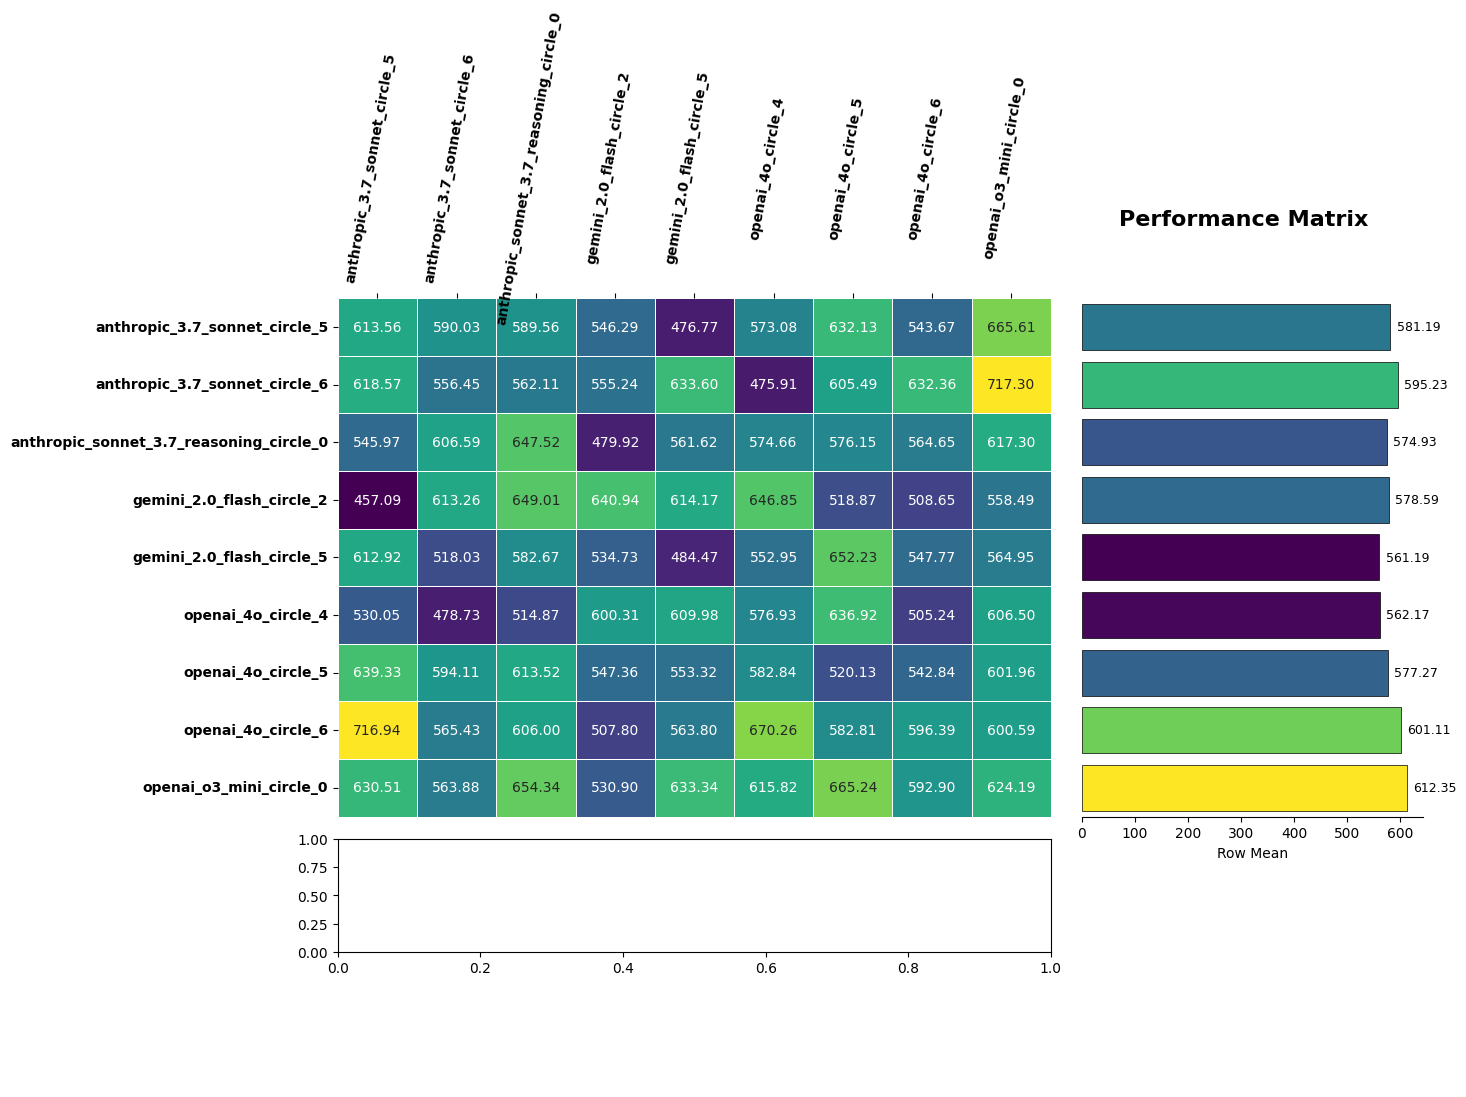

Calculating means for Scaled Performance Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.50720125 0.58299649 0.51733852 0.56056648 0.58267315 0.58825424
 0.58588852 0.48954787 0.59826518]
Mean: 0.5569701890042631


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


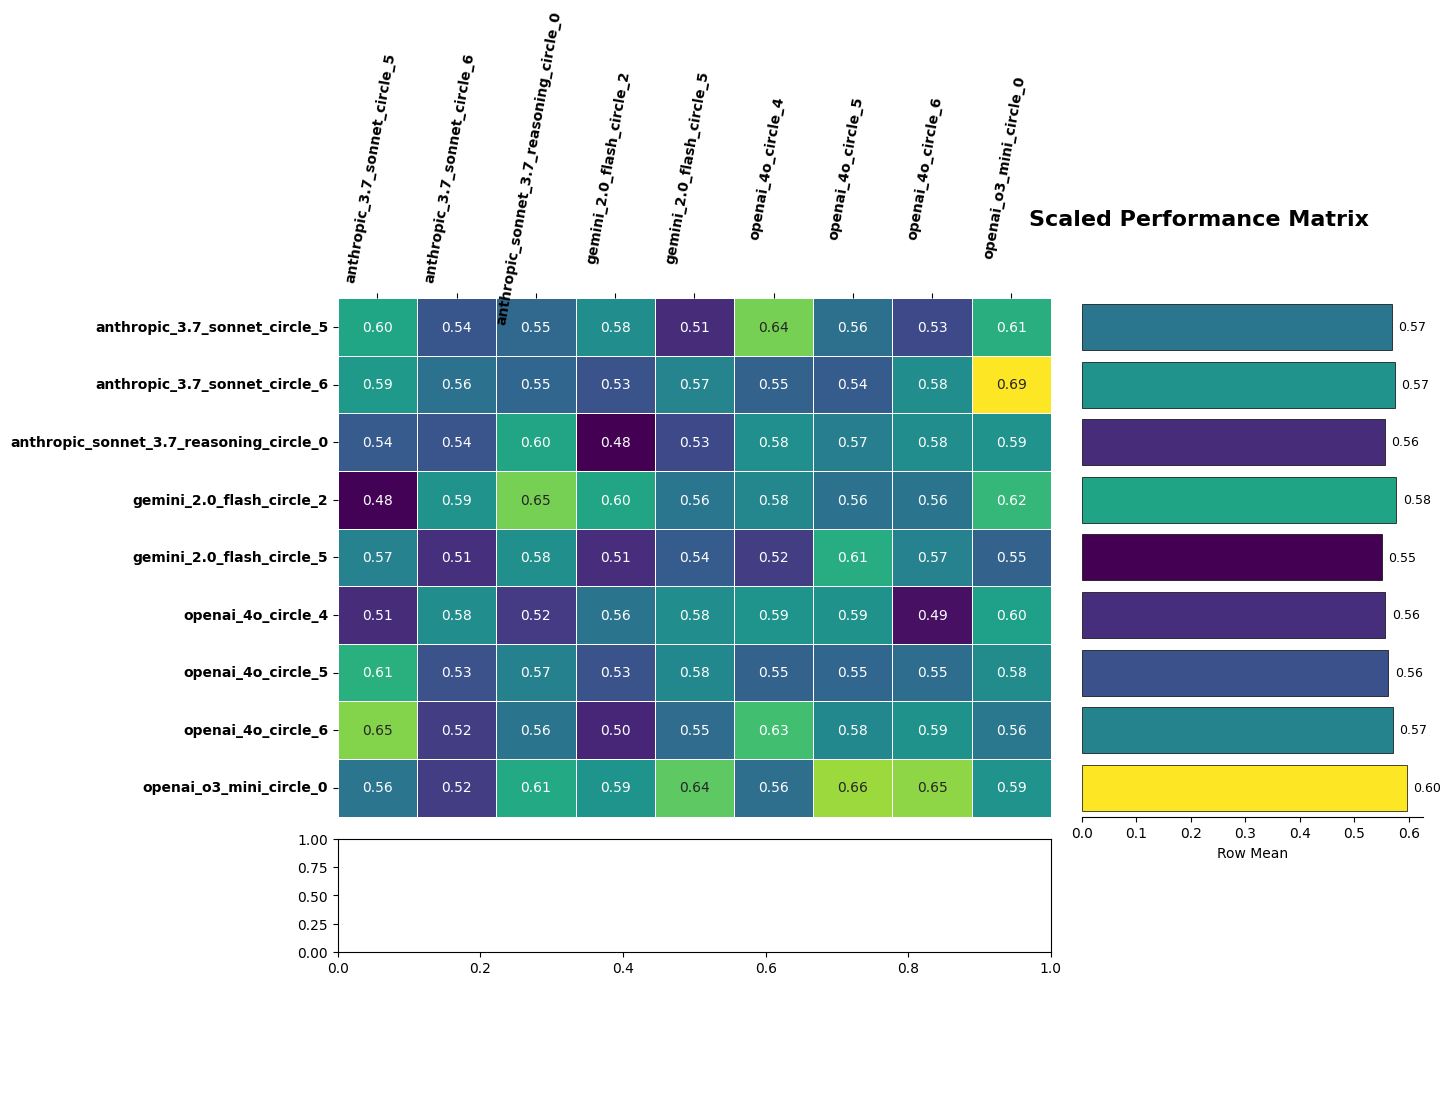

Calculating means for Nash Welfare Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.77674259 0.66595695 0.73497448 0.80693311 0.78851603 0.80857188
 0.84598617 0.80076272 0.84704405]
Mean: 0.7861653310970771


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


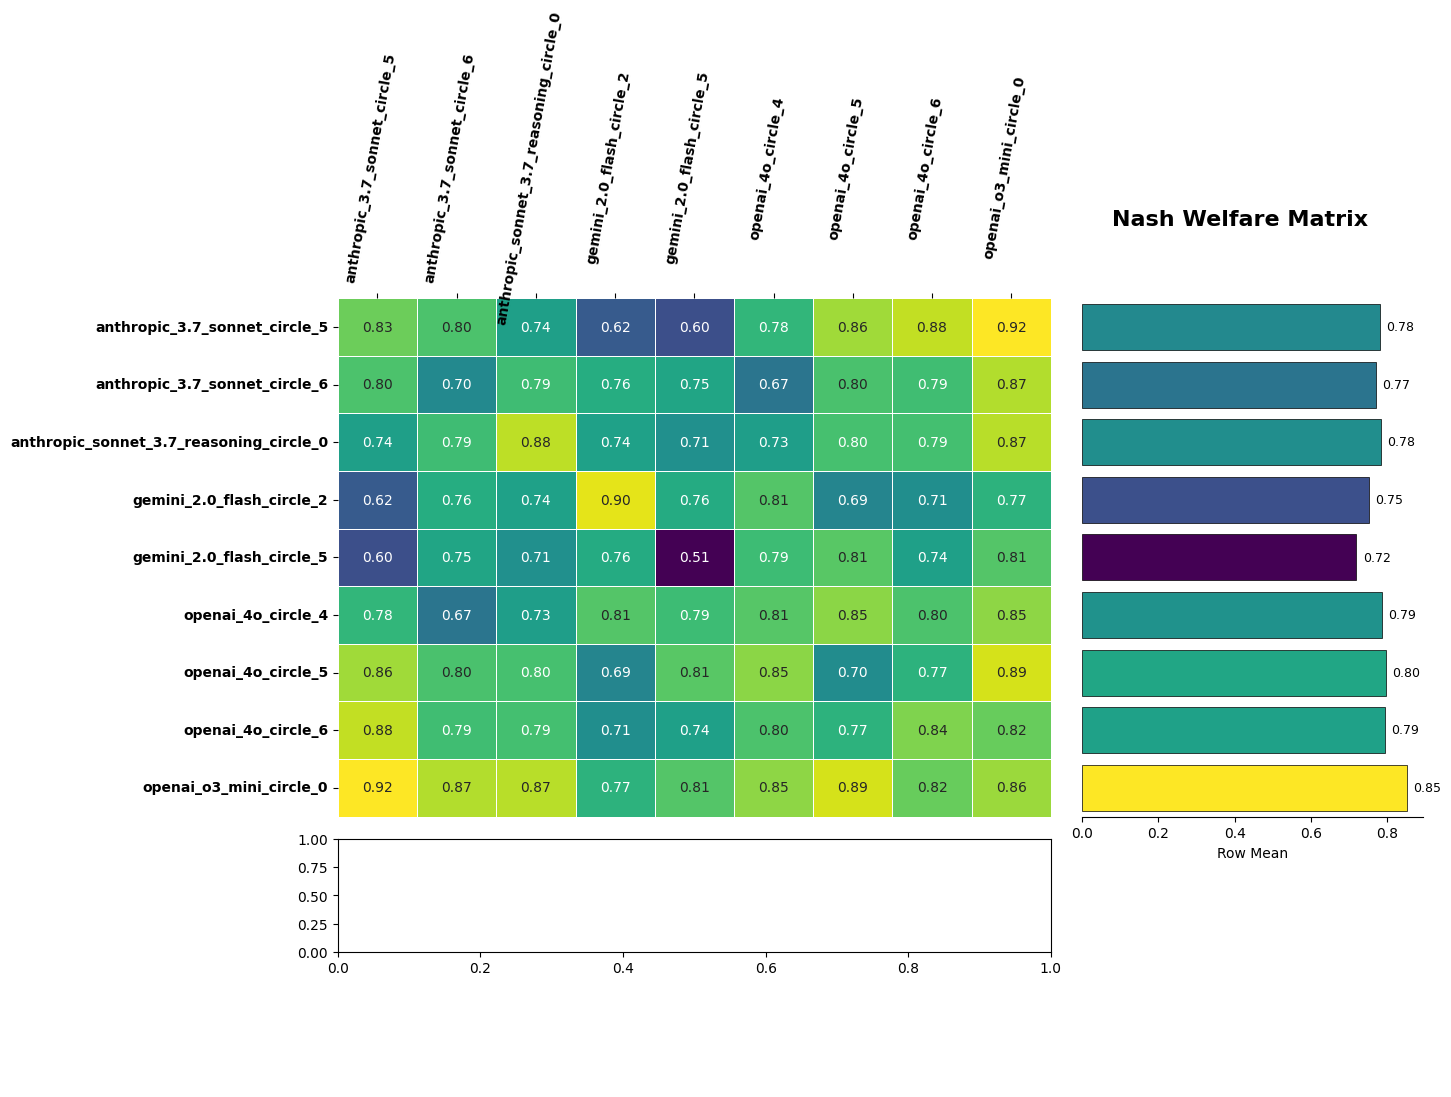

Calculating means for Utilitarian Welfare Matrix:
Example row (openai_4o_circle_4 if available):
Values: [1103.12370256  954.64420513 1089.53196842 1247.16493333 1162.92833846
 1153.85512941 1219.76102    1175.50511795 1222.32306316]
Mean: 1147.648608714068


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


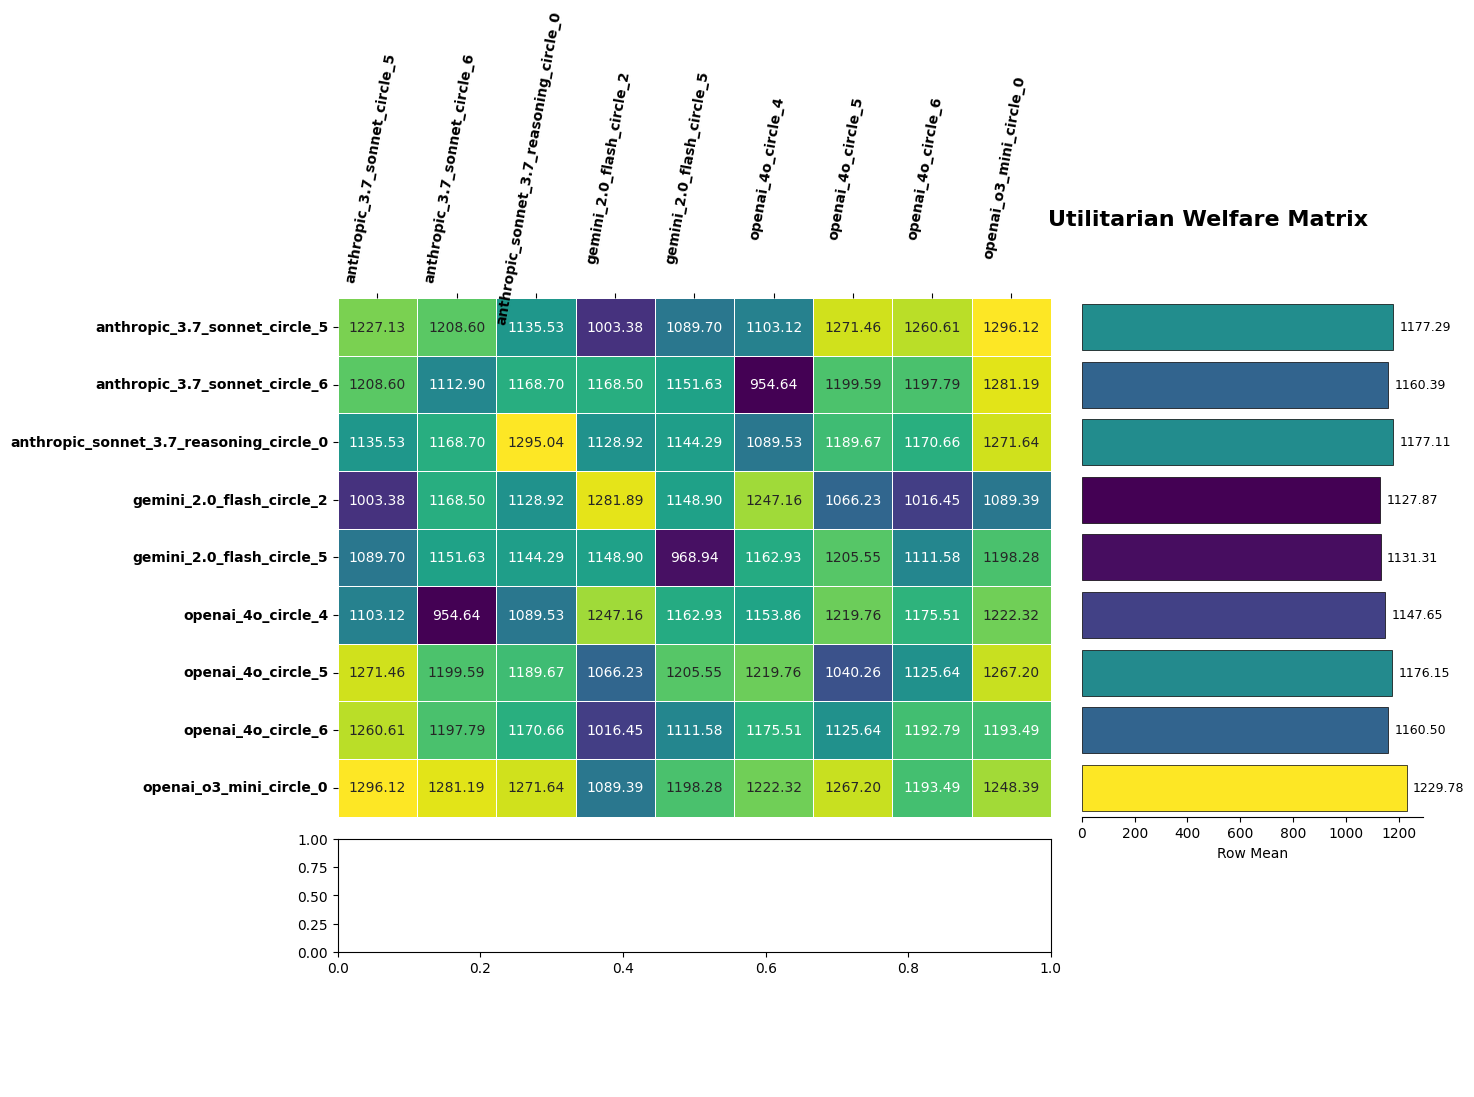

Calculating means for Rawls Welfare Matrix:
Example row (openai_4o_circle_4 if available):
Values: [406.69527179 344.5346359  356.14732632 396.16361111 383.7630359
 423.47070588 442.54209    401.37420513 424.21707368]
Mean: 397.6564395234903


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


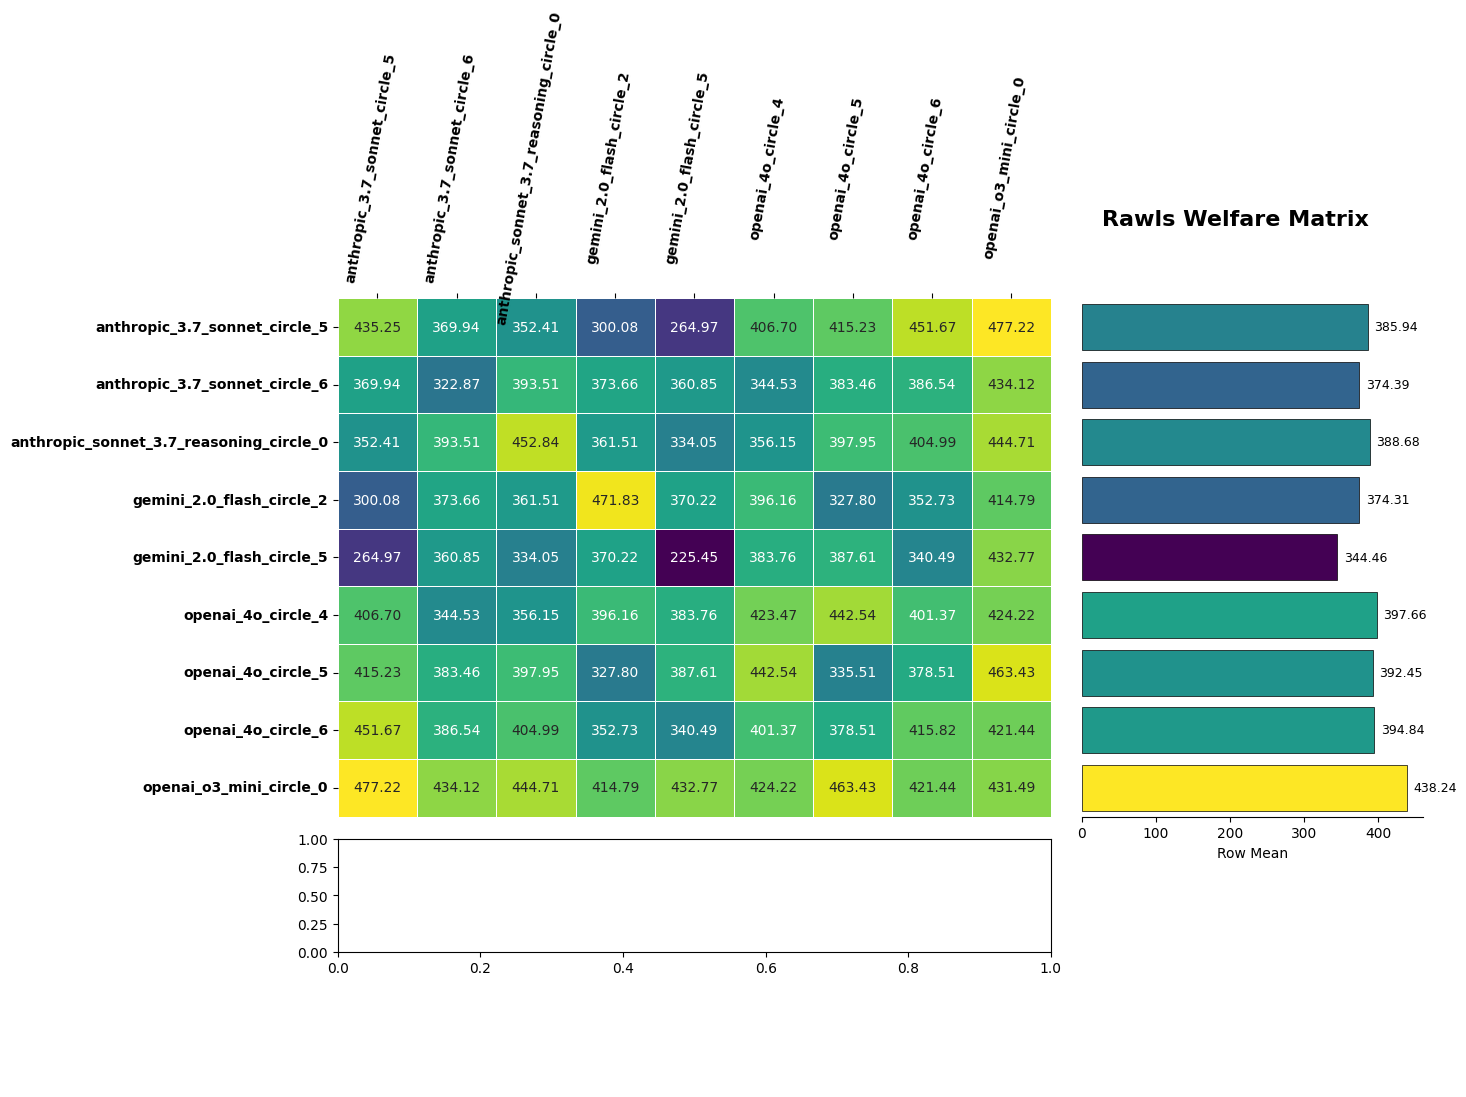

Calculating means for Gini Coefficient Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.14066006 0.14819452 0.18301354 0.17921503 0.17004882 0.14915525
 0.15667    0.16276491 0.1494249 ]
Mean: 0.15990522606583832


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


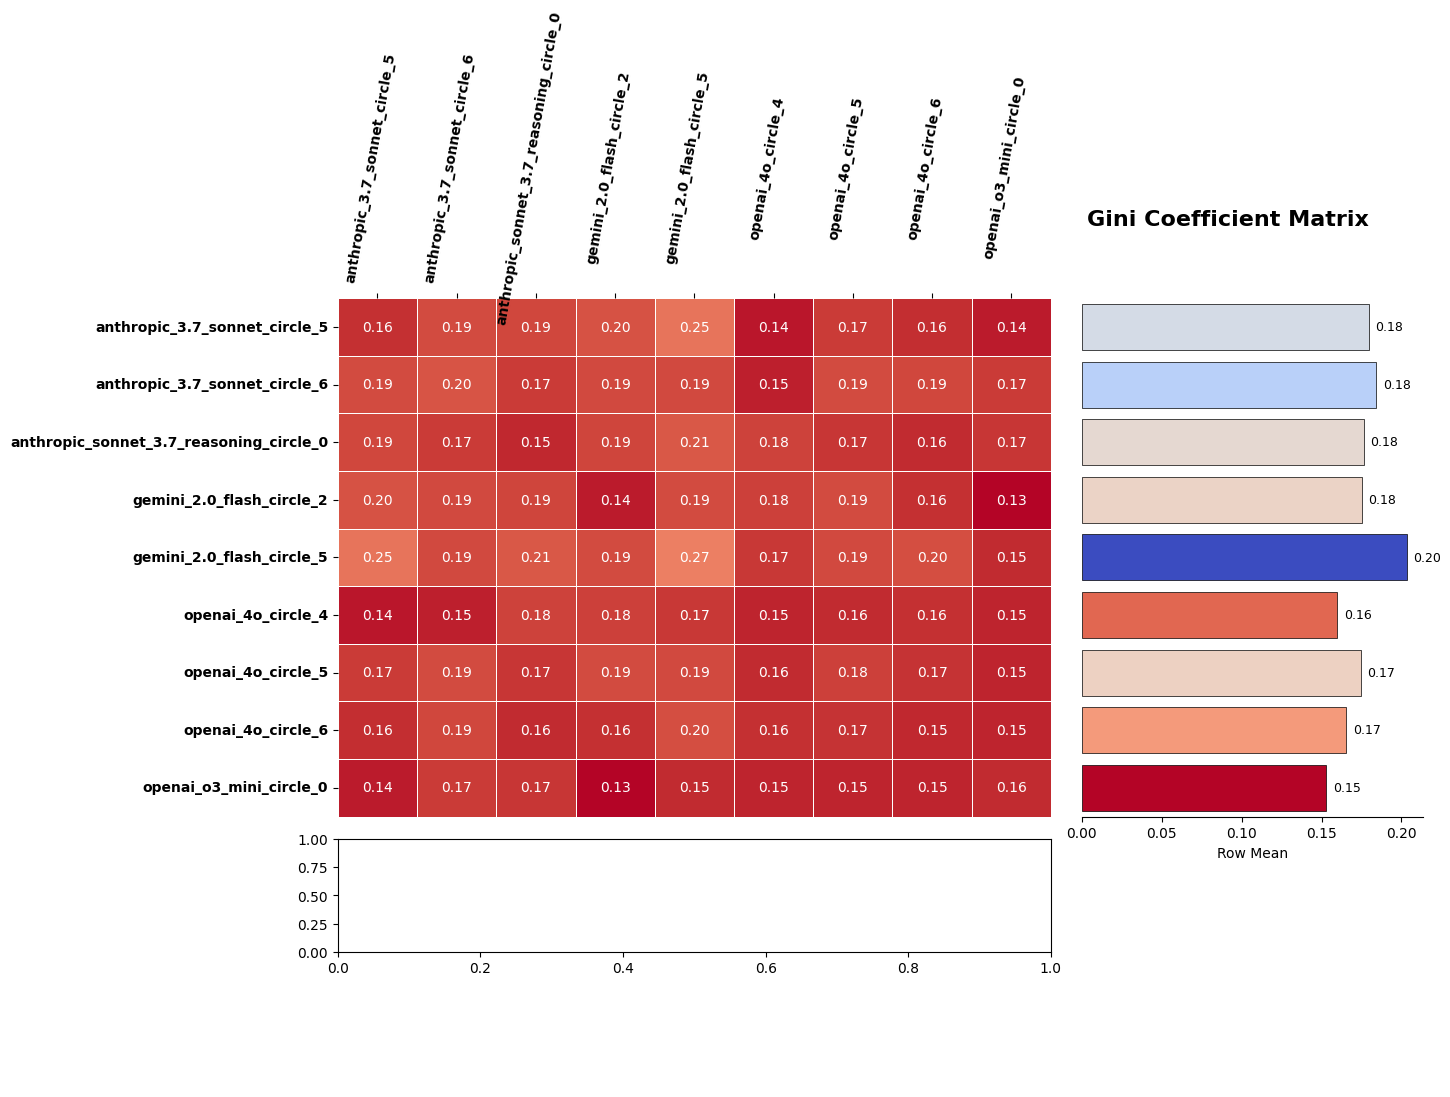

Calculating means for Jain's Fairness Index Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.9062945  0.89852443 0.86193973 0.8641248  0.87690806 0.89231712
 0.88507655 0.88036138 0.89937081]
Mean: 0.8849908188452752


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


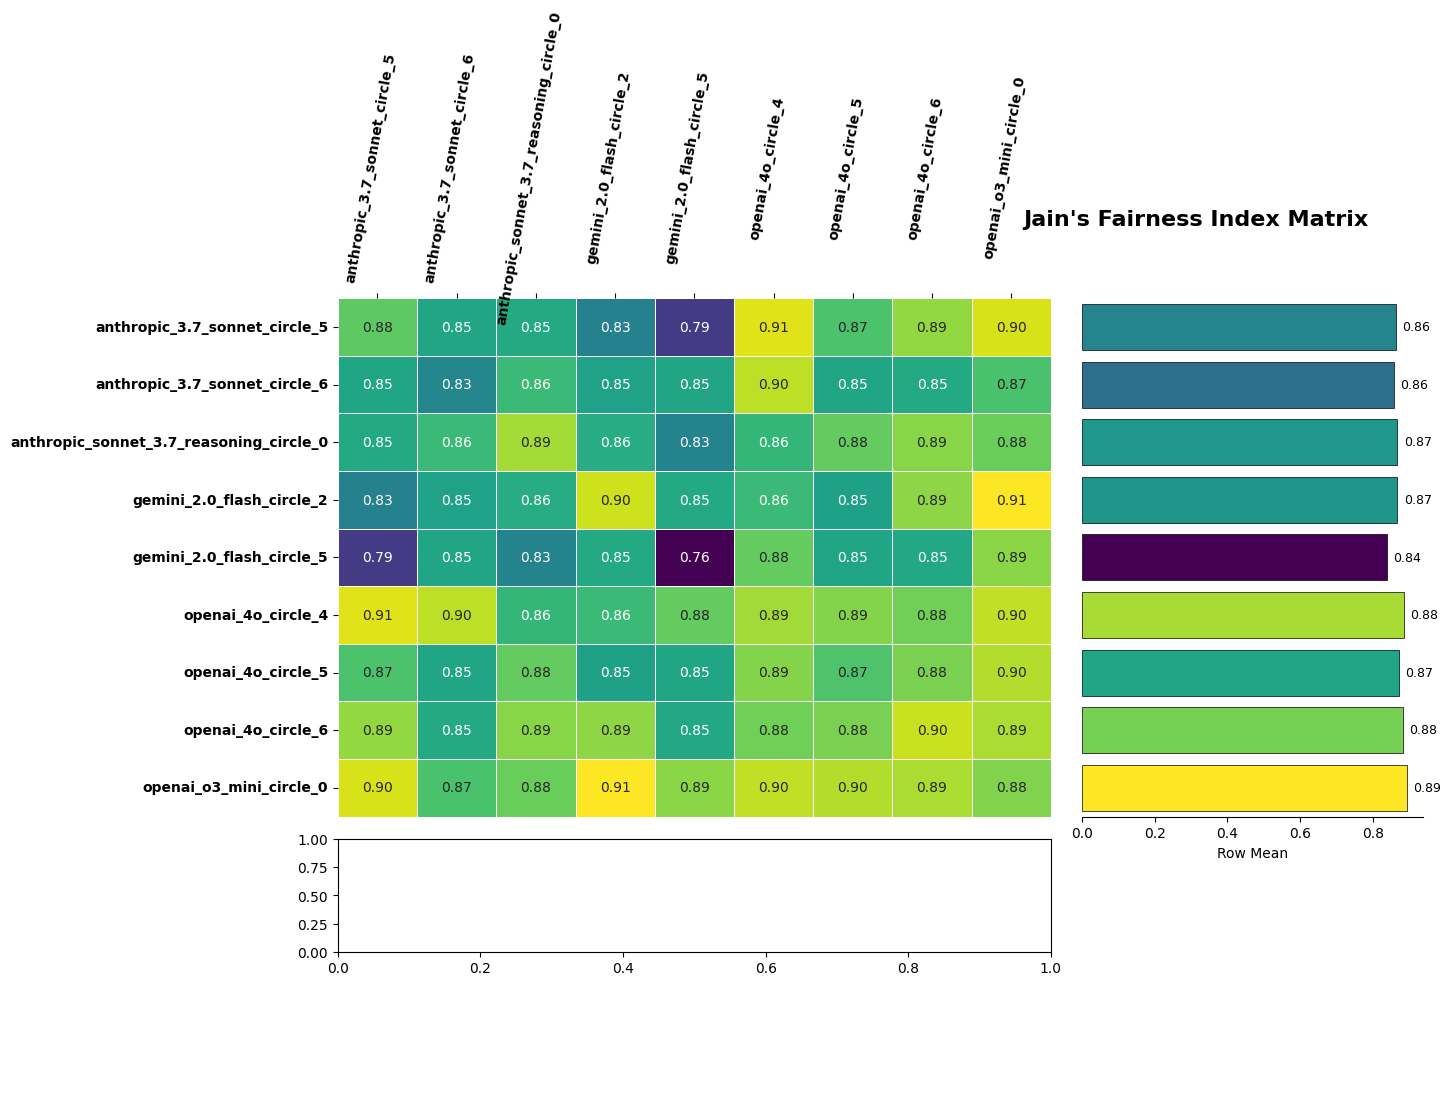

Calculating means for Envy-Free Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.07692308 0.07692308 0.18421053 0.         0.05128205 0.
 0.1        0.07692308 0.10526316]
Mean: 0.07461388514020094


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


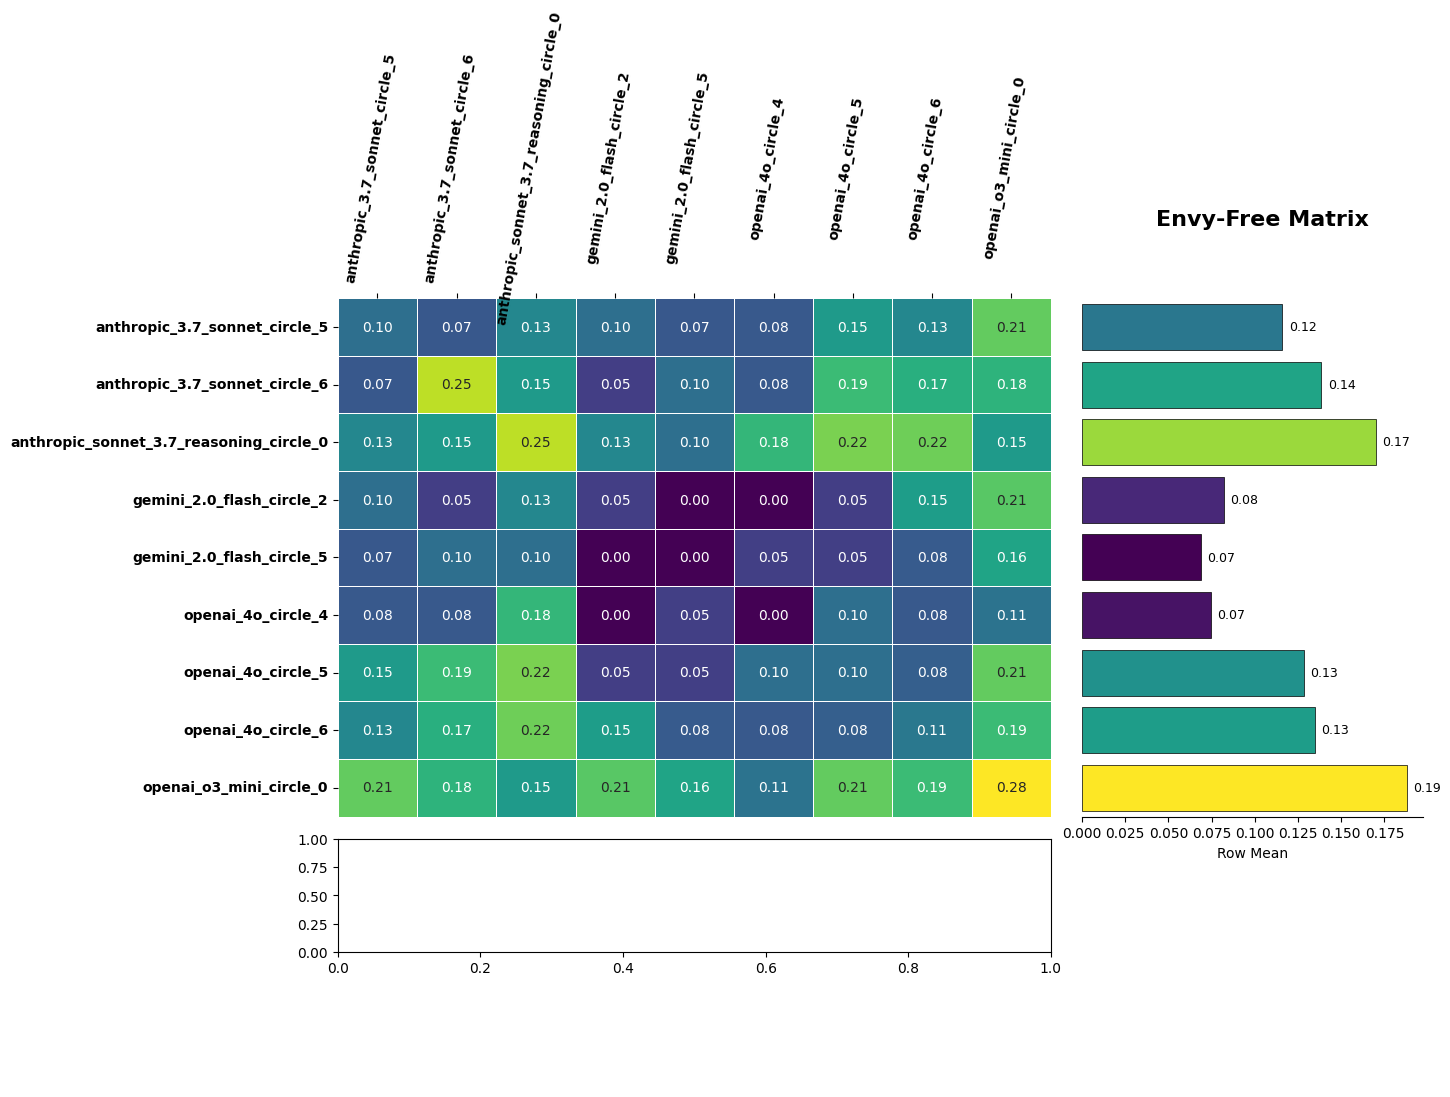

Calculating means for EF1 Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.23076923 0.1025641  0.28947368 0.11111111 0.1025641  0.05882353
 0.225      0.15384615 0.26315789]
Mean: 0.1708122010237593


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


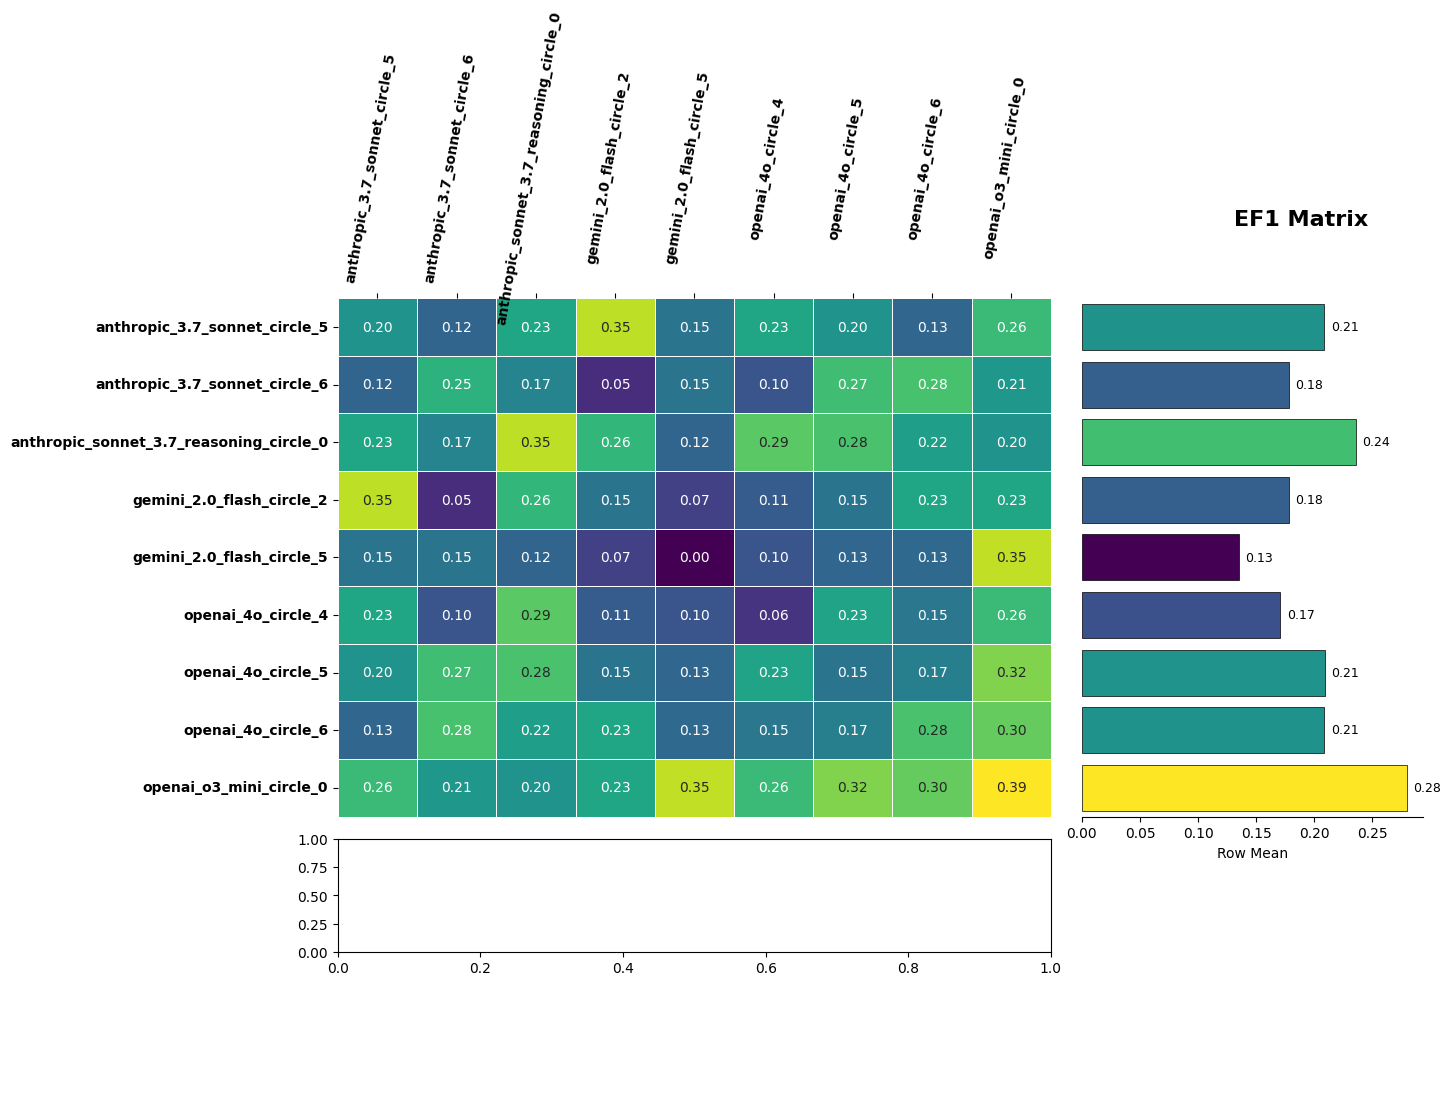

Calculating means for Pareto-Front-Count:
Example row (openai_4o_circle_4 if available):
Values: [0.1025641  0.02564103 0.07894737 0.02777778 0.         0.
 0.         0.02564103 0.07894737]
Mean: 0.037724296496226314


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


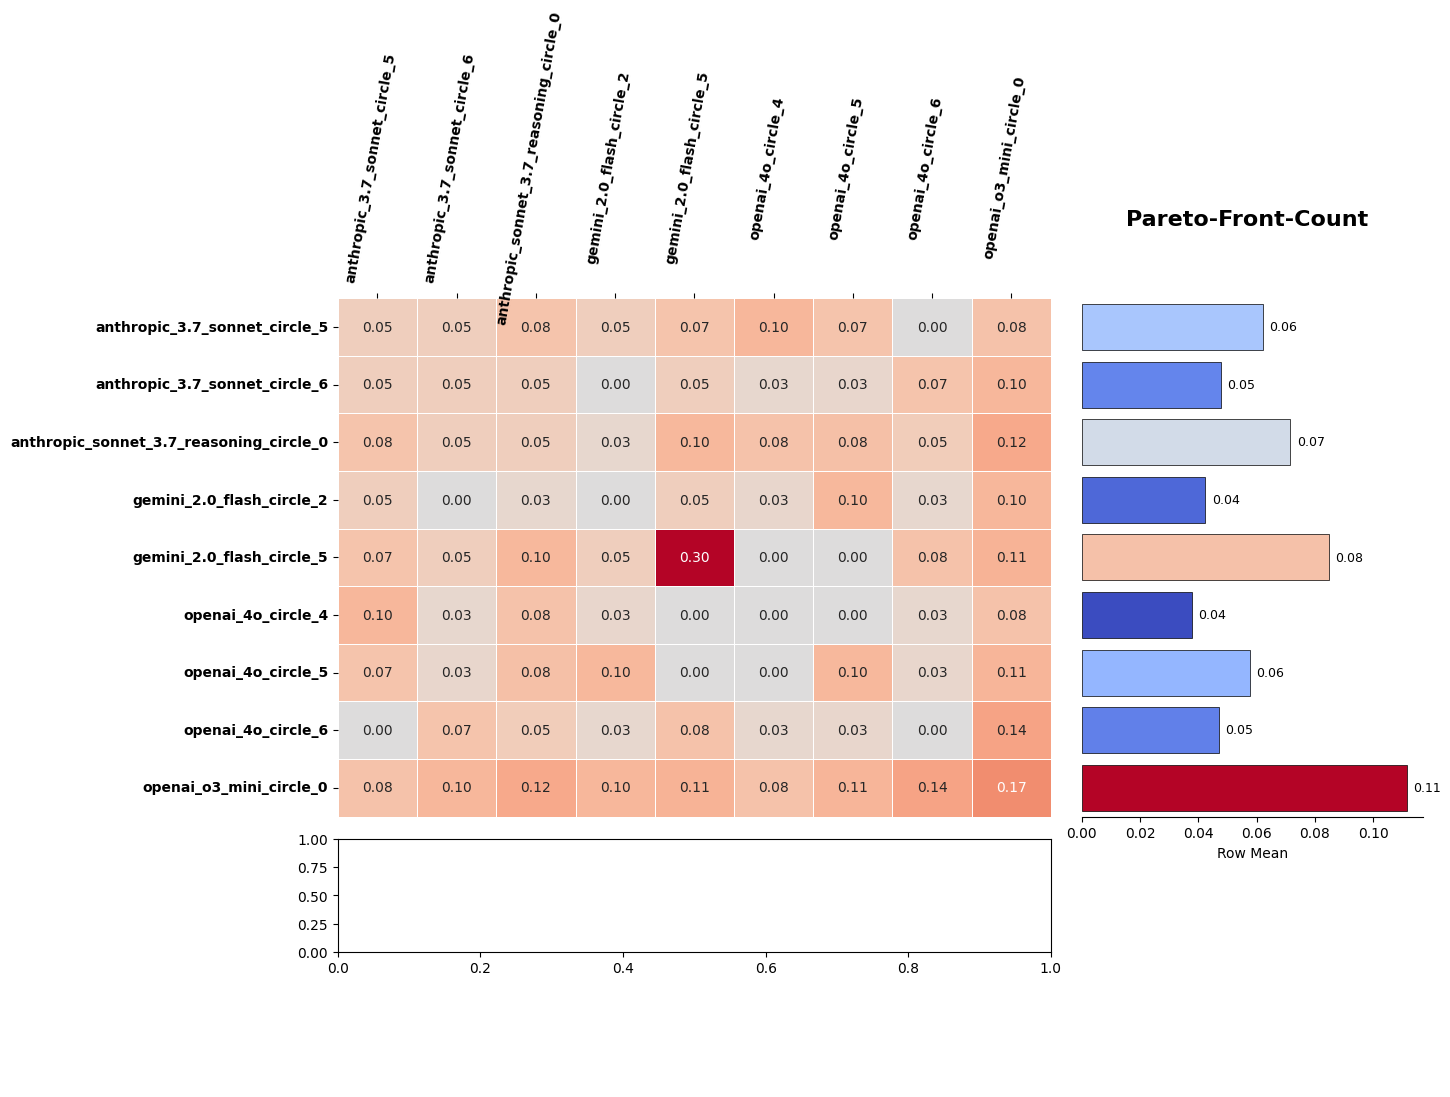

In [22]:
for matrix_name, matrix in [
    ("Performance Matrix", performance_matrix),
    ("Scaled Performance Matrix", scaled_performance_matrix),
    ("Nash Welfare Matrix", nash_welfare_matrix),
    ("Utilitarian Welfare Matrix", utilitarian_welfare_matrix),
    ("Rawls Welfare Matrix", rawls_welfare_matrix),
    ("Gini Coefficient Matrix", gini_matrix),
    ("Jain's Fairness Index Matrix", jain_matrix),
    ("Envy-Free Matrix", envy_free_matrix),
    ("EF1 Matrix", ef1_matrix),
    ("Pareto-Front-Count", pareto_matrix)
]:
    if matrix_name in ["Performance Matrix", "Scaled Performance Matrix", "Nash Welfare Matrix", 
                       "Utilitarian Welfare Matrix", 
                       "Rawls Welfare Matrix"]:
        cmap = "viridis" 
        center = None
    elif matrix_name in ["Gini Coefficient Matrix"]:
        cmap = "coolwarm_r"
        center = 0.5
    elif matrix_name in ["Jain's Fairness Index Matrix", "Envy-Free Matrix", "EF1 Matrix"]:
        cmap = "viridis"
        center = None
    else:
        cmap = "coolwarm"
        center = 0
    
    fig = create_matrix_heatmap_with_marginals(matrix, title=matrix_name, cmap=cmap, center=center)
    plt.show()

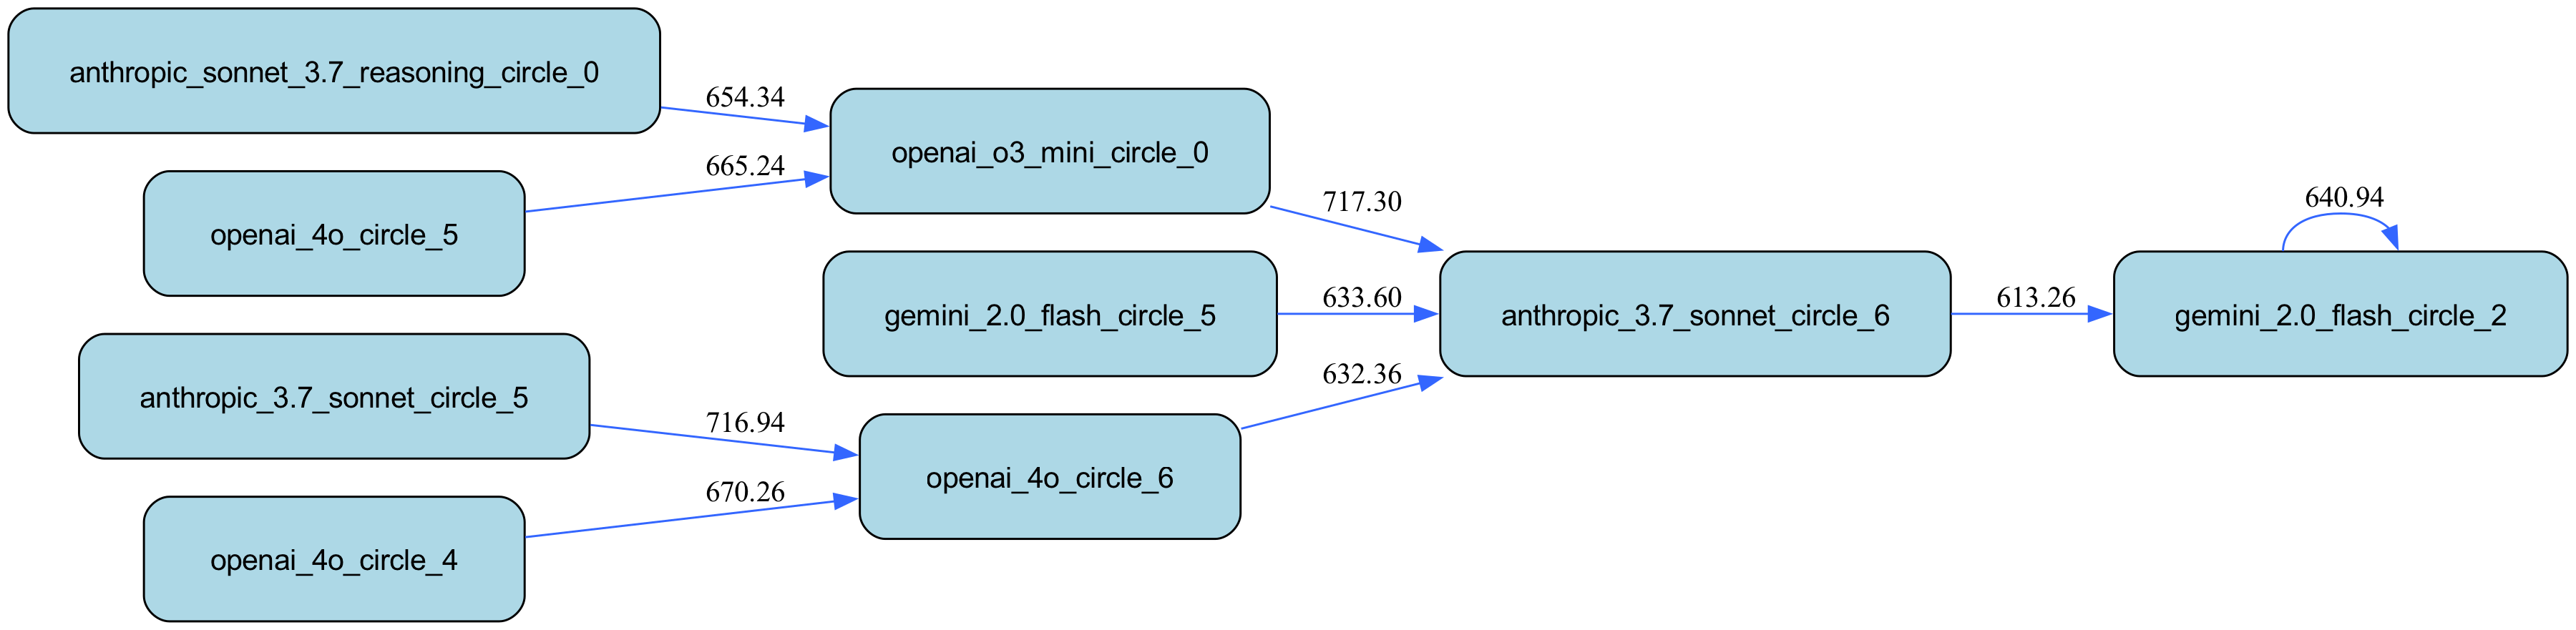

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

dot = Digraph(comment='NW Response Graph', format='png')
dot.attr(rankdir='LR', size='12,8', dpi='300', bgcolor='white')
dot.attr('node', shape='box', style='filled,rounded', fillcolor='lightblue', 
         fontname='Arial', fontsize='14', margin='0.4,0.3')  # Increased margin to prevent text cutoff

strategy_names = performance_matrix.columns.tolist()

for strategy in strategy_names:
    short_name = strategy
    # if len(strategy) > 15:  # Reduced character limit to ensure text fits
    #     short_name = strategy[:12] + "..."
    
    dot.node(strategy, short_name, width='2.5', height='0.8')

for strategy in strategy_names:
    column_values = performance_matrix[strategy]
    
    best_response = column_values.idxmax()
    best_value = column_values.max()
    
    dot.edge(strategy, best_response, label=f" {best_value:.2f}", color='#3366FF')

dot.render('best_response_graph_graphviz', view=True, cleanup=True)

from IPython.display import Image, display
display(Image('best_response_graph_graphviz.png'))

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

def create_complete_best_response_graph(performance_matrix, filename='complete_best_response'):
    """
    Create a complete best response graph showing both player perspectives

    Parameters:
    - performance_matrix: DataFrame containing payoffs (rows are P1 strategies, columns are P2 strategies)
    - filename: base name for output files
    """
    dot = Digraph(comment='Complete Best Response Graph', format='png')
    dot.attr(rankdir='LR', size='14,10', dpi='300', bgcolor='white')
    dot.attr('node', shape='box', style='filled,rounded', fontname='Arial', fontsize='14', margin='0.4,0.3')
    
    strategy_names = performance_matrix.columns.tolist()

    for strategy in strategy_names:
        dot.node(strategy, strategy, width='2.5', height='0.8', fillcolor='lightblue')
    
    for p2_strategy in strategy_names:
        p1_payoffs = performance_matrix[p2_strategy]
        
        p1_best_response = p1_payoffs.idxmax()
        p1_best_value = p1_payoffs.max()
        
        dot.edge(p2_strategy, p1_best_response, 
                label=f" P1:{p1_best_value:.2f}", 
                color='#3366FF', 
                fontcolor='#3366FF')
    
 
    p2_matrix = performance_matrix.transpose()  
    
    for p1_strategy in strategy_names:
        p2_payoffs = p2_matrix[p1_strategy]
        
        p2_best_response = p2_payoffs.idxmax()
        p2_best_value = p2_payoffs.max()
        
        dot.edge(p1_strategy, p2_best_response, 
                label=f" P2:{p2_best_value:.2f}", 
                color='#FF6347', 
                fontcolor='#FF6347')
    
    dot.render(filename, view=True, cleanup=True)
    
    return dot


best_response_graph = create_complete_best_response_graph(performance_matrix)

Running bootstrapping with 100 samples...

Computing 95% confidence intervals...

Agent Performance with Confidence Intervals:


,Agent,Mean NE Regret,Std NE Regret,Lower 95% CI (Regret),Upper 95% CI (Regret),Mean Traditional Regret,Std Traditional Regret,Lower 95% CI (Trad Regret),Upper 95% CI (Trad Regret),Mean Expected Utility,Std Expected Utility,Lower 95% CI (Utility),Upper 95% CI (Utility)
4,gemini_2.0_flash_circle_5,-17.376372,14.712410,-20.295634,-14.457111,64.928698,28.953791,59.183637,70.673758,587.682279,8.890807,585.918150,589.446408
5,openai_4o_circle_4,-16.987739,15.531287,-20.069483,-13.905994,61.181785,20.136810,57.186205,65.177365,588.070913,9.492151,586.187464,589.954361
3,gemini_2.0_flash_circle_2,-16.634692,16.404498,-19.889700,-13.379683,86.102623,21.128604,81.910249,90.294996,588.423960,9.657491,586.507704,590.340215
6,openai_4o_circle_5,-15.174103,15.041518,-18.158666,-12.189539,63.478547,25.598890,58.399172,68.557922,589.884549,11.338423,587.634759,592.134338
2,anthropic_sonnet_3.7_reasoning_circle_0,-4.435478,14.343073,-7.281455,-1.589501,56.541005,25.988023,51.384417,61.697593,600.623173,18.020551,597.047505,604.198841
7,openai_4o_circle_6,5.156923,24.707611,0.254397,10.059449,116.579463,40.042798,108.634103,124.524823,610.215575,21.132213,606.022485,614.408664
1,anthropic_3.7_sonnet_circle_6,6.117573,25.152876,1.126696,11.108449,109.090184,38.700754,101.411115,116.769253,611.176224,30.980430,605.029034,617.323413
0,anthropic_3.7_sonnet_circle_5,7.321934,20.237795,3.306316,11.337551,53.606967,24.099471,48.825109,58.388825,612.380585,23.917141,607.634905,617.126264
8,openai_o3_mini_circle_0,26.719090,20.623263,22.626987,30.811193,51.738532,23.619572,47.051897,56.425168,631.777742,21.312534,627.548873,636.006611



Plotting regret distributions...

Computing acceptance ratio matrix...
Processing 1560 game results
Looking for 9 agent types: ['anthropic_3.7_sonnet_circle_5', 'anthropic_3.7_sonnet_circle_6', 'anthropic_sonnet_3.7_reasoning_circle_0']...
Found 9 unique agents in results
Example agents in results: ['openai_o3_mini_2025-01-31_circle_0', 'gemini_2.0_flash_circle_5', 'openai_4o_2024-08-06_circle_5']...
Normalized match: 'openai_o3_mini_2025-01-31_circle_0' → 'openai_o3_mini_circle_0'
Normalized match: 'gemini_2.0_flash_circle_5' → 'gemini_2.0_flash_circle_5'
Normalized match: 'openai_4o_2024-08-06_circle_5' → 'openai_4o_circle_5'
Normalized match: 'anthropic_3.7_sonnet_2025-02-19_circle_5' → 'anthropic_3.7_sonnet_circle_5'
Normalized match: 'anthropic_3.7_sonnet_2025-02-19_circle_6' → 'anthropic_3.7_sonnet_circle_6'
Normalized match: 'openai_4o_2024-08-06_circle_6' → 'openai_4o_circle_6'
Normalized match: 'gemini_2.0_flash_circle_2' → 'gemini_2.0_flash_circle_2'
Normalized match: 'anthr

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,anthropic_sonnet_3.7_reasoning_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,0.6,0.75,0.75,0.7,0.8,0.625,0.55,0.575,0.525
anthropic_3.7_sonnet_circle_6,0.75,0.75,0.675,0.4,0.7,0.625,0.725,0.75,0.525
anthropic_sonnet_3.7_reasoning_circle_0,0.75,0.675,0.55,0.475,0.7,0.7,0.65,0.6,0.475
gemini_2.0_flash_circle_2,0.7,0.4,0.475,0.45,0.7,0.475,0.675,0.65,0.5
gemini_2.0_flash_circle_5,0.8,0.7,0.7,0.7,0.75,0.5,0.425,0.625,0.5
openai_4o_circle_4,0.625,0.625,0.7,0.475,0.5,0.45,0.55,0.55,0.575
openai_4o_circle_5,0.55,0.725,0.65,0.675,0.425,0.55,0.7,0.525,0.575
openai_4o_circle_6,0.575,0.75,0.6,0.65,0.625,0.55,0.525,0.6,0.525
openai_o3_mini_circle_0,0.525,0.525,0.475,0.5,0.5,0.575,0.575,0.525,0.6



Creating acceptance ratio heatmap...
Calculating means for Acceptance Ratio Matrix:
Example row (openai_4o_circle_4 if available):
Values: [0.625 0.625 0.7   0.475 0.5   0.45  0.55  0.55  0.575]
Mean: 0.5611111111111111

Computing overall Nash equilibrium strategy...

Nash Equilibrium Mixed Strategy (Probability Distribution):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_21779/1230346074.py:169: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


,Agent,Nash Probability
8,openai_o3_mini_circle_0,0.317081
2,anthropic_sonnet_3.7_reasoning_circle_0,0.206545
6,openai_4o_circle_5,0.191445
5,openai_4o_circle_4,0.163739
3,gemini_2.0_flash_circle_2,0.046770
0,anthropic_3.7_sonnet_circle_5,0.035498
4,gemini_2.0_flash_circle_5,0.027701
1,anthropic_3.7_sonnet_circle_6,0.011195
7,openai_4o_circle_6,0.000026


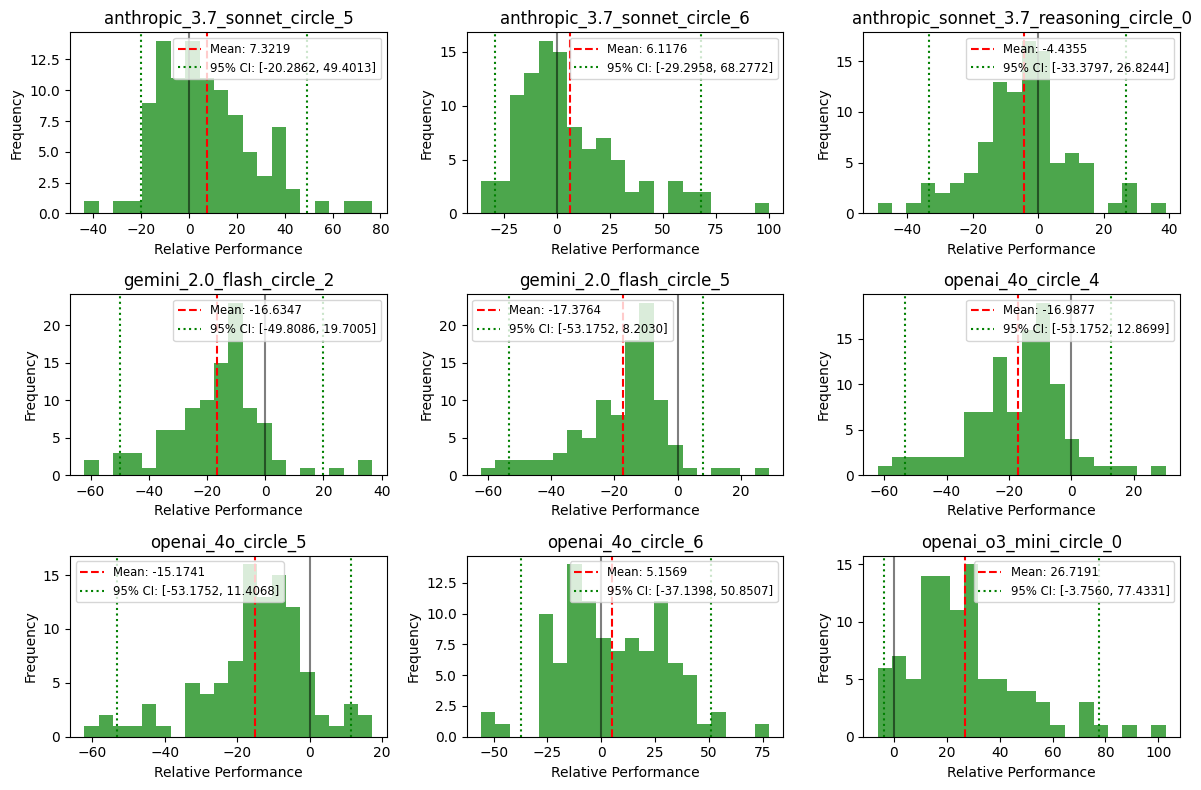

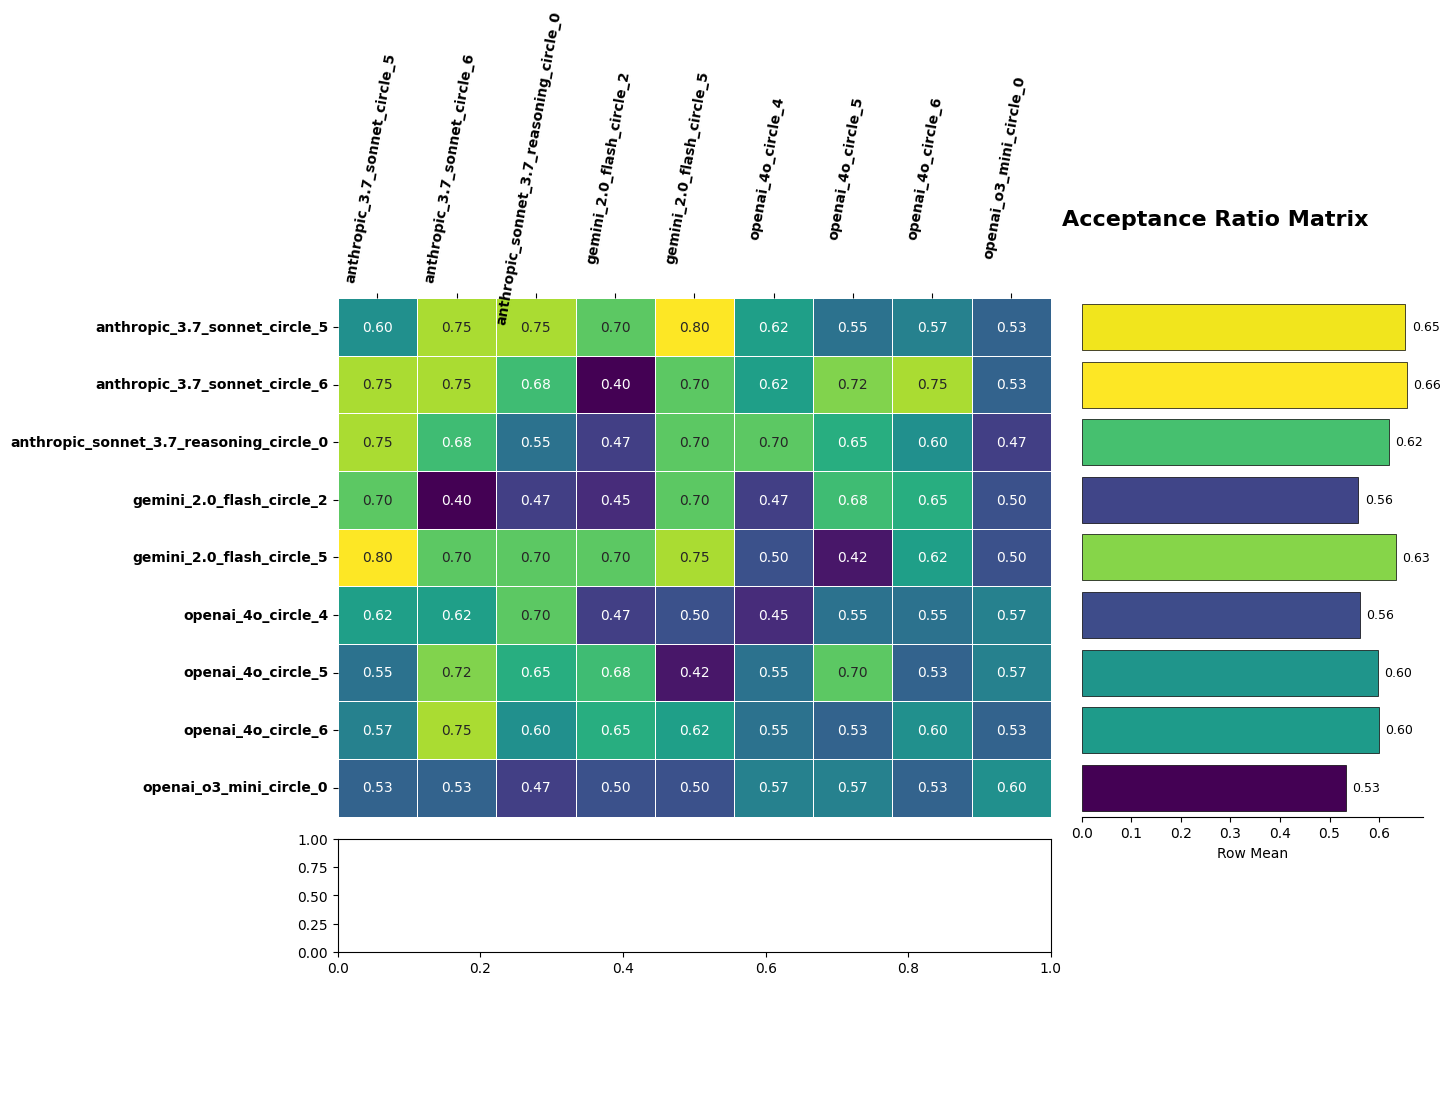

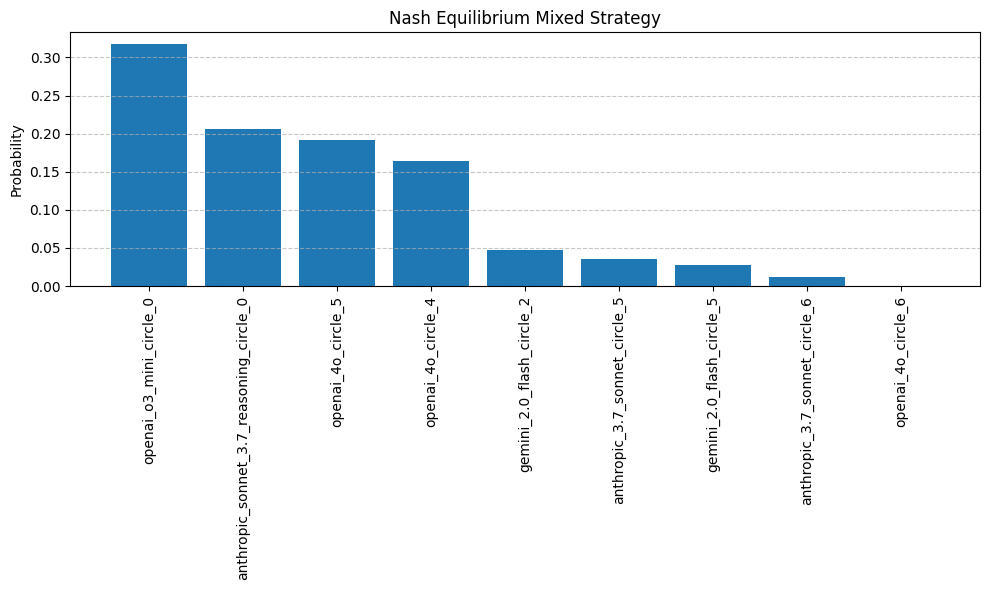


Statistical Summary of Nash Equilibrium Analysis:
Average NE regret across all agents: -2.8103
Maximum average regret: 26.7191
Minimum average regret: -17.3764
Standard deviation of average regrets: 14.4438

Top 5 agents by Nash Equilibrium analysis (lowest regret):


,Agent,Mean NE Regret,Std NE Regret
4,gemini_2.0_flash_circle_5,-17.376372,14.712410
5,openai_4o_circle_4,-16.987739,15.531287
3,gemini_2.0_flash_circle_2,-16.634692,16.404498
6,openai_4o_circle_5,-15.174103,15.041518
2,anthropic_sonnet_3.7_reasoning_circle_0,-4.435478,14.343073


In [25]:
from nash_equilibrium import (
    bootstrap_performance_metrics,
    analyze_bootstrap_results,
    plot_regret_distributions,
    compute_acceptance_ratio_matrix
)

agents_for_bootstrap = performance_matrix.index.tolist()

num_bootstrap_samples = 100
print(f"Running bootstrapping with {num_bootstrap_samples} samples...")
bootstrap_results = bootstrap_performance_metrics(
    performance_matrix, 
    num_bootstrap=num_bootstrap_samples, 
    with_replacement=True
)

confidence_level = 0.95
print(f"\nComputing {confidence_level*num_bootstrap_samples:.0f}% confidence intervals...")
bootstrap_stats = analyze_bootstrap_results(
    bootstrap_results, 
    agents_for_bootstrap, 
    confidence=confidence_level
)

print("\nAgent Performance with Confidence Intervals:")
display(bootstrap_stats)

print("\nPlotting regret distributions...")
regret_fig = plot_regret_distributions(bootstrap_results, agents_for_bootstrap)

print("\nComputing acceptance ratio matrix...")
acceptance_matrix = compute_acceptance_ratio_matrix(all_results, agents_for_bootstrap)
acceptance_matrix = clean_matrix_names(acceptance_matrix)

print("\nAcceptance Ratio Matrix:")
display(acceptance_matrix)

print("\nCreating acceptance ratio heatmap...")
fig = create_matrix_heatmap_with_marginals(
    acceptance_matrix, 
    title="Acceptance Ratio Matrix", 
    cmap="viridis", 
    center=None
)

print("\nComputing overall Nash equilibrium strategy...")
avg_ne_strategy = np.mean([s for s in bootstrap_results['ne_strategy']], axis=0)

ne_strategy_df = pd.DataFrame({
    'Agent': agents_for_bootstrap,
    'Nash Probability': avg_ne_strategy
}).sort_values(by='Nash Probability', ascending=False)

print("\nNash Equilibrium Mixed Strategy (Probability Distribution):")
display(ne_strategy_df)

plt.figure(figsize=(10, 6))
plt.bar(ne_strategy_df['Agent'], ne_strategy_df['Nash Probability'])
plt.xticks(rotation=90)
plt.title('Nash Equilibrium Mixed Strategy')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

ne_regrets = np.array(bootstrap_results['ne_regret'])
mean_regrets = np.mean(ne_regrets, axis=0)
std_regrets = np.std(ne_regrets, axis=0)

print("\nStatistical Summary of Nash Equilibrium Analysis:")
print(f"Average NE regret across all agents: {np.mean(mean_regrets):.4f}")
print(f"Maximum average regret: {np.max(mean_regrets):.4f}")
print(f"Minimum average regret: {np.min(mean_regrets):.4f}")
print(f"Standard deviation of average regrets: {np.std(mean_regrets):.4f}")

top_agents = bootstrap_stats.head(5)
print("\nTop 5 agents by Nash Equilibrium analysis (lowest regret):")
display(top_agents[['Agent', 'Mean NE Regret', 'Std NE Regret']])

In [26]:

#%%writefile nash_regret_viz.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def create_matrix_heatmap_with_nash_regret(performance_matrix, nash_regrets, title="Performance Matrix with Nash Regret", 
                                         cmap="coolwarm", figsize=(16, 12)):
    """
    Parameters:
    - performance_matrix: pandas DataFrame containing the performance data
    - nash_regrets: Series or DataFrame containing Nash regret values for each agent
    - title: title for the plot
    - cmap: colormap to use
    - figsize: figure size (width, height)
    
    Returns:
    - fig: the matplotlib figure
    """
    numeric_matrix = performance_matrix.copy()
    
    for col in numeric_matrix.columns:
        numeric_matrix[col] = pd.to_numeric(numeric_matrix[col], errors='coerce')
    
    mask = np.isnan(numeric_matrix)
    
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(1, 5, figure=fig, width_ratios=[4, 1, 0.2, 0.2, 0.2])
    
    ax_heatmap = fig.add_subplot(gs[0, 0])
    
    ax_regret = fig.add_subplot(gs[0, 1])
    
    sns.heatmap(numeric_matrix, ax=ax_heatmap, cmap=cmap, annot=True, fmt=".2f",
                cbar=False, linewidths=0.5, mask=mask)
    
    ax_heatmap.set_title(title, fontsize=16, fontweight='bold')
    ax_heatmap.set_xticklabels(ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    ax_heatmap.set_yticklabels(ax_heatmap.get_yticklabels(), fontweight='bold')
    
    regrets = pd.Series(index=numeric_matrix.index)
    
    #now I gotta process nash_regrets to get values
    if isinstance(nash_regrets, pd.DataFrame):
        if 'Mean NE Regret' in nash_regrets.columns and 'Agent' in nash_regrets.columns:
            
            regrets_dict = dict(zip(nash_regrets['Agent'], nash_regrets['Mean NE Regret']))
            for agent in numeric_matrix.index:
                if agent in regrets_dict:
                    regrets[agent] = regrets_dict[agent]
                else:
                    regrets[agent] = np.nan
        else:
            for agent in numeric_matrix.index:
                if agent in nash_regrets.index:
                    for col in nash_regrets.columns:
                        if 'regret' in col.lower():
                            regrets[agent] = nash_regrets.loc[agent, col]
                            break
                    if np.isnan(regrets[agent]):
                        for col in nash_regrets.columns:
                            if pd.api.types.is_numeric_dtype(nash_regrets[col]):
                                regrets[agent] = nash_regrets.loc[agent, col]
                                break
    elif isinstance(nash_regrets, pd.Series):
        for agent in numeric_matrix.index:
            if agent in nash_regrets.index:
                regrets[agent] = nash_regrets[agent]
    
    regrets = regrets.dropna()
    
    regrets = regrets.sort_values(ascending=True)
    
    if len(regrets) > 0:
        colors = plt.cm.viridis(np.linspace(0, 1, len(regrets)))
        bars = ax_regret.barh(range(len(regrets)), regrets.values, color=colors)
        
        for i, value in enumerate(regrets.values):
            ax_regret.text(value + (max(regrets.values) * 0.02), i, f"{value:.2f}", 
                          va='center', fontsize=9)
        
        ax_regret.set_yticks(range(len(regrets)))
        ax_regret.set_yticklabels(regrets.index, fontweight='bold')
        
        ax_regret.set_xlabel('Nash Equilibrium Regret', fontweight='bold')
        ax_regret.set_title('NE Regret', fontweight='bold')
        
        ax_regret.spines['top'].set_visible(False)
        ax_regret.spines['right'].set_visible(False)
    else:
        ax_regret.text(0.5, 0.5, "No valid Nash regret data", 
                      ha='center', va='center', fontsize=12)
        ax_regret.axis('off')
    
    plt.tight_layout()
    return fig

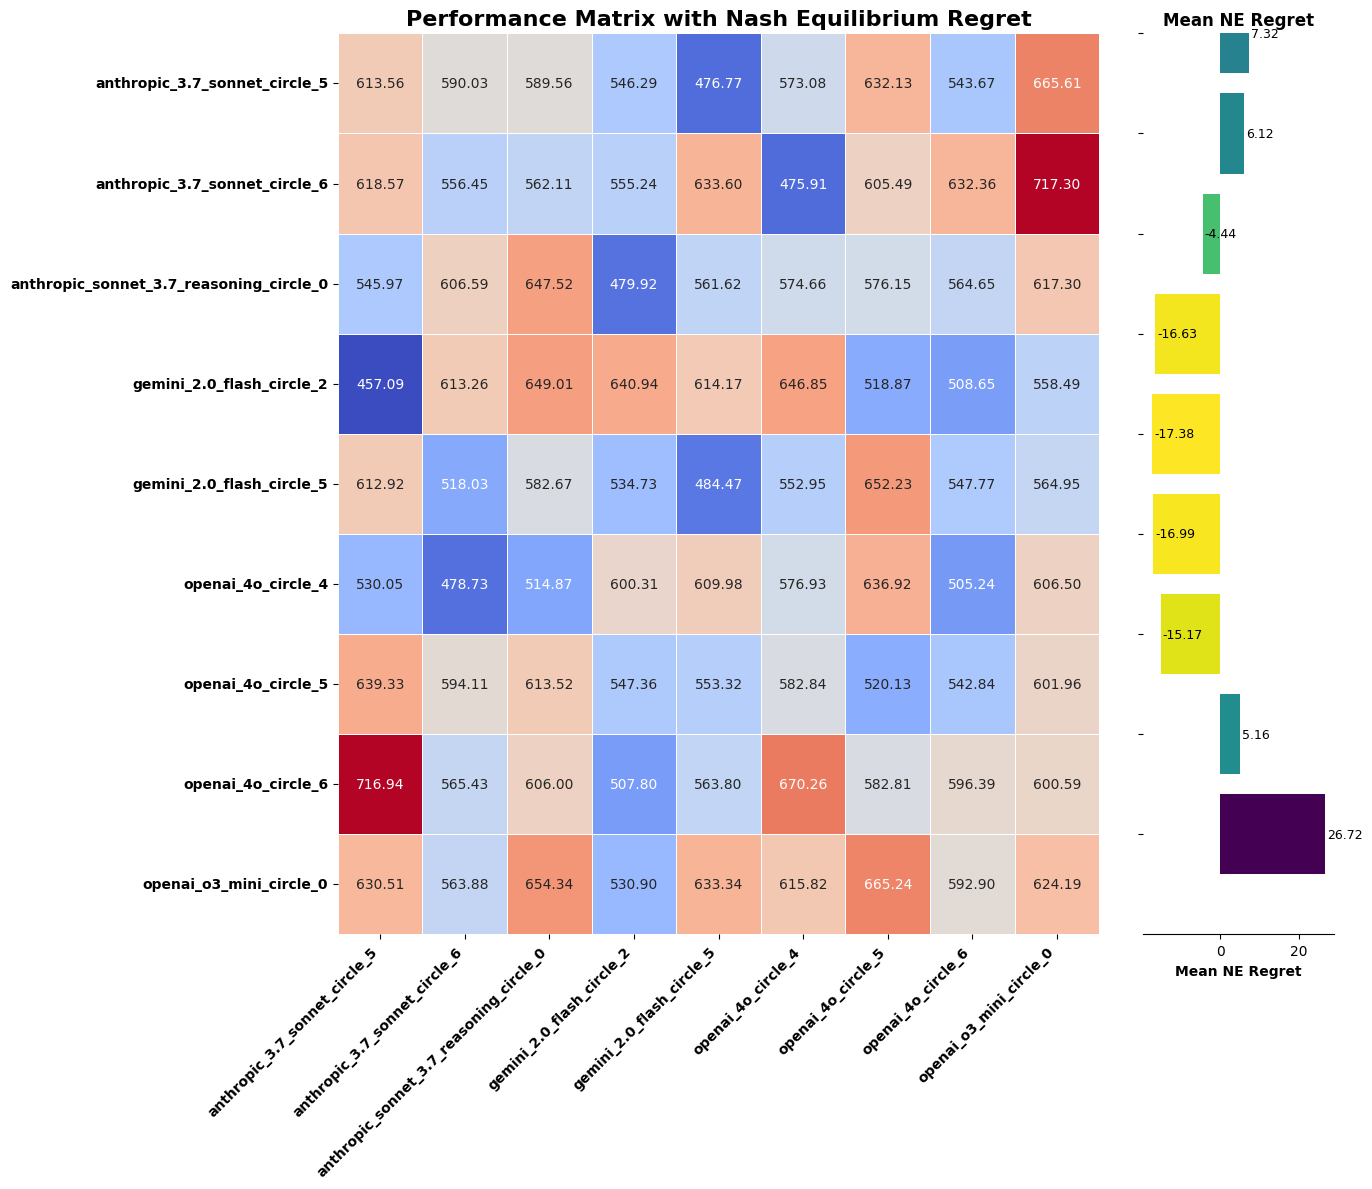

Index(['Agent', 'Mean NE Regret', 'Std NE Regret', 'Lower 95% CI (Regret)',
       'Upper 95% CI (Regret)', 'Mean Traditional Regret',
       'Std Traditional Regret', 'Lower 95% CI (Trad Regret)',
       'Upper 95% CI (Trad Regret)', 'Mean Expected Utility',
       'Std Expected Utility', 'Lower 95% CI (Utility)',
       'Upper 95% CI (Utility)'],
      dtype='object')


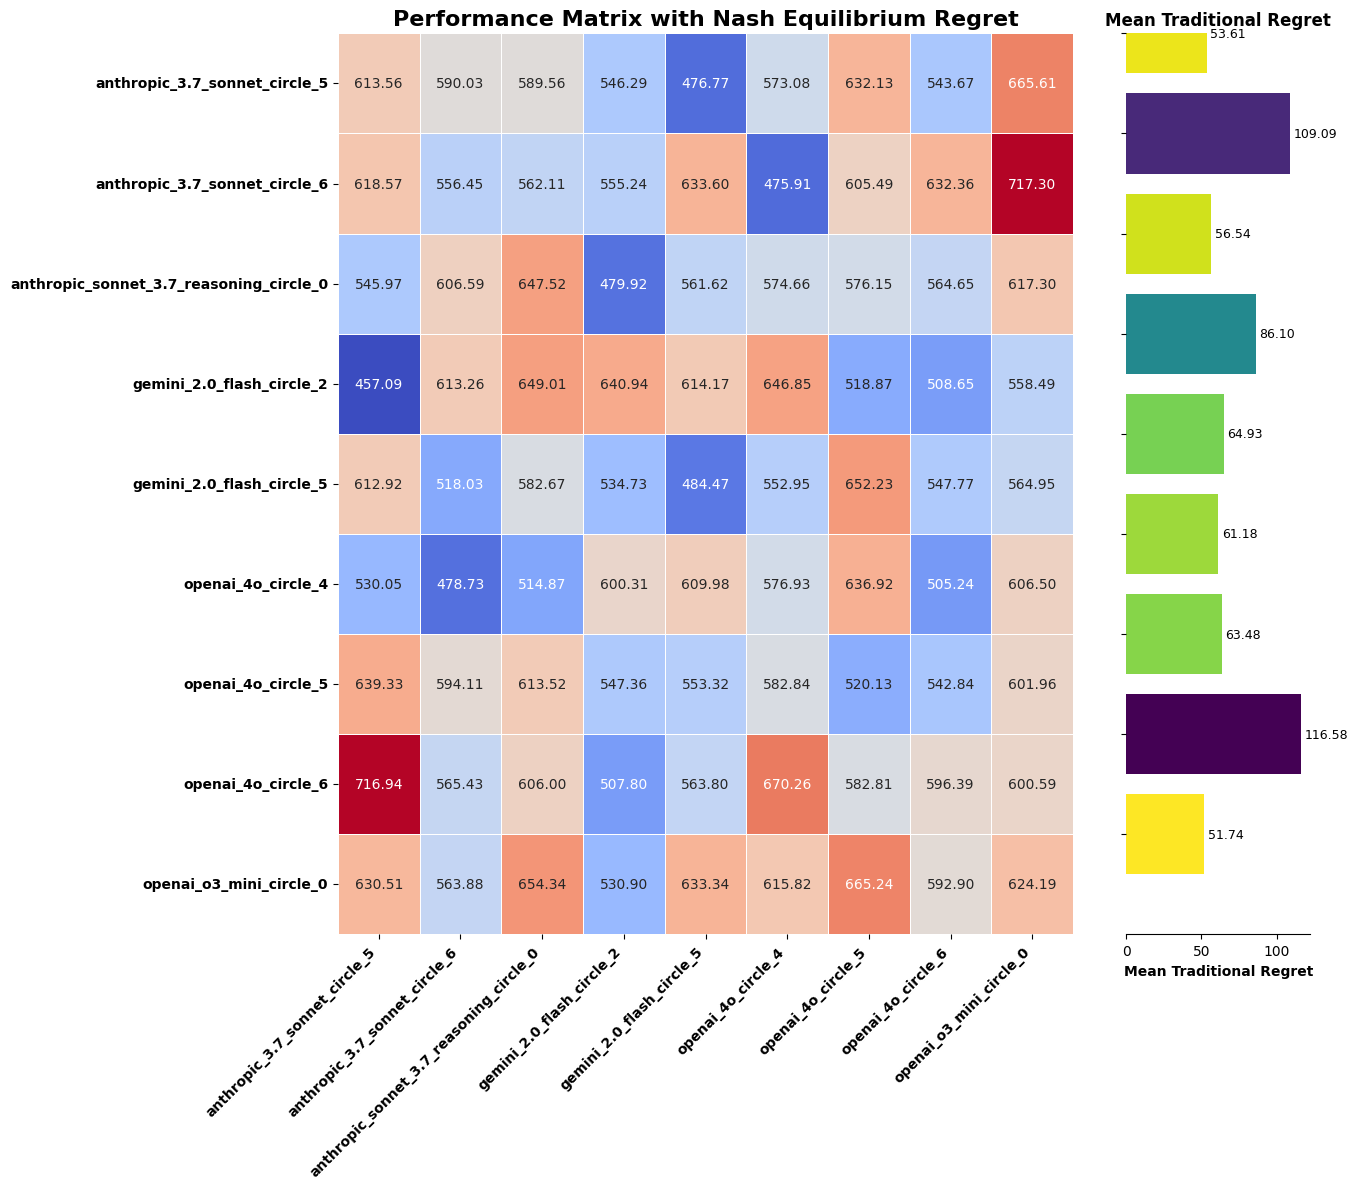

In [27]:
from nash_regret_viz import create_matrix_heatmap_with_nash_regret

regret_heatmap = create_matrix_heatmap_with_nash_regret(
    performance_matrix, 
    bootstrap_stats,
    regret_type='Mean NE Regret',  
    title="Performance Matrix with Nash Equilibrium Regret"
)
plt.show()
print(bootstrap_stats.keys())
regret_heatmap = create_matrix_heatmap_with_nash_regret(
    performance_matrix, 
    bootstrap_stats,
    regret_type='Mean Traditional Regret',  
    title="Performance Matrix with Nash Equilibrium Regret"
)
plt.show()



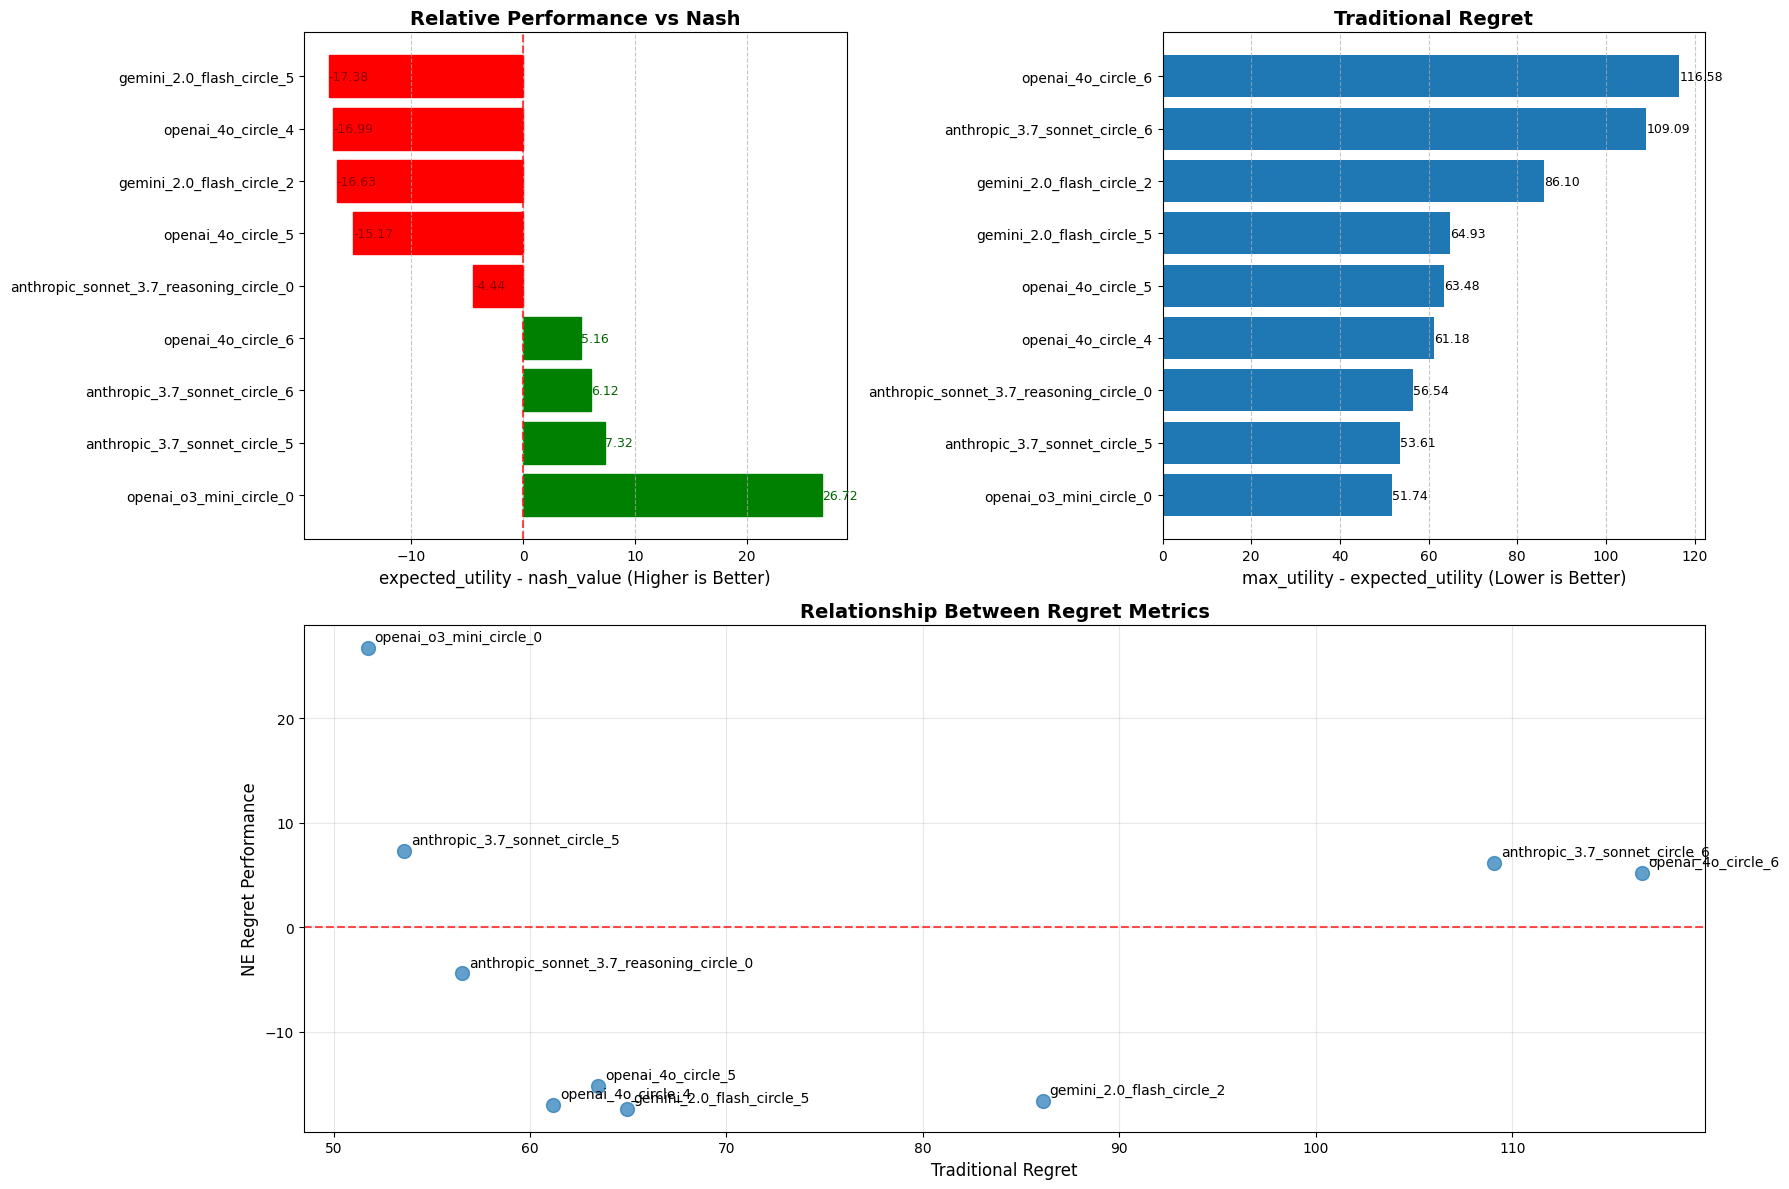

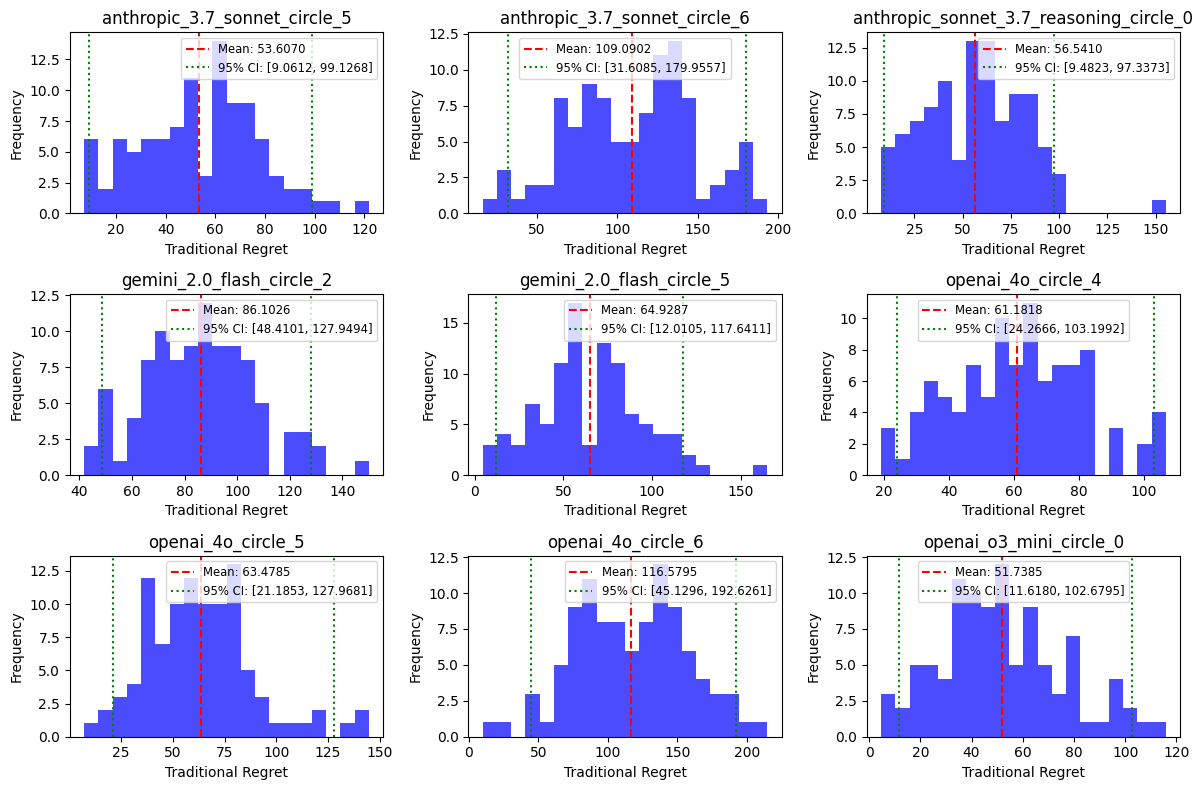

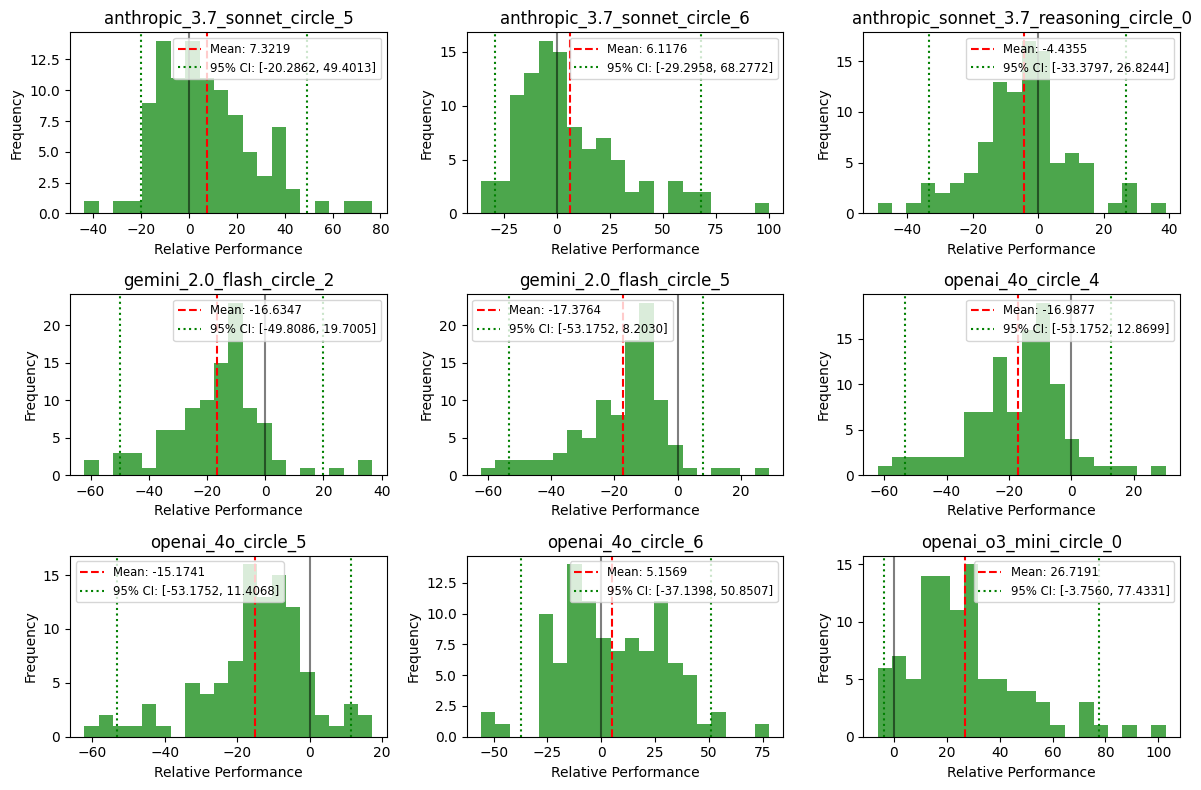


Top 5 agents by Traditional Regret:


,Agent,Mean Traditional Regret,Std Traditional Regret
8,openai_o3_mini_circle_0,51.738532,23.619572
0,anthropic_3.7_sonnet_circle_5,53.606967,24.099471
2,anthropic_sonnet_3.7_reasoning_circle_0,56.541005,25.988023
5,openai_4o_circle_4,61.181785,20.136810
6,openai_4o_circle_5,63.478547,25.598890



Top 5 agents by Relative Performance:


,Agent,Mean NE Regret,Std NE Regret
8,openai_o3_mini_circle_0,26.719090,20.623263
0,anthropic_3.7_sonnet_circle_5,7.321934,20.237795
1,anthropic_3.7_sonnet_circle_6,6.117573,25.152876
7,openai_4o_circle_6,5.156923,24.707611
2,anthropic_sonnet_3.7_reasoning_circle_0,-4.435478,14.343073


In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nash_equilibrium.bootstrap import bootstrap_performance_metrics, analyze_bootstrap_results, visualize_dual_regret, plot_regret_distributions
from nash_equilibrium.nash_regret_viz import create_dual_regret_heatmap

dual_regret_fig = visualize_dual_regret(
    bootstrap_results, 
    agents_for_bootstrap
)
plt.show()

trad_regret_fig = plot_regret_distributions(
    bootstrap_results, 
    agents_for_bootstrap,
    regret_type='traditional_regret'
)
plt.show()

rel_perf_fig = plot_regret_distributions(
    bootstrap_results, 
    agents_for_bootstrap,
    regret_type='ne_regret'
)
plt.show()




print("\nTop 5 agents by Traditional Regret:")
display(bootstrap_stats.sort_values('Mean Traditional Regret').head(5)[['Agent', 'Mean Traditional Regret', 'Std Traditional Regret']])

print("\nTop 5 agents by Relative Performance:")
display(bootstrap_stats.sort_values('Mean NE Regret', ascending=False).head(5)[['Agent', 'Mean NE Regret', 'Std NE Regret']])
